In [1]:
import torch

# Check CUDA availability
if torch.cuda.is_available():
    print("✅ GPU is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("❌ GPU not available, using CPU.")
    device = torch.device("cpu")


✅ GPU is available!
Using GPU: NVIDIA L4


In [2]:
# !pip install --user nltk textstat tqdm

In [3]:
import pandas as pd

In [4]:
pwd

'/shared/home/chs0610/neuro140_final_project/notebooks'

In [5]:
data = pd.read_csv('../data/all_with_punctuation.csv')
data.head()

,text,class
0,latest headlines on cnn business tl;dr the u.s...,ctrl
1,china wants to take a victory lap over its han...,ctrl
2,coronavirus disinformation creates challenges ...,ctrl
3,china coronavirus: eating wild animals made il...,ctrl
4,china's economy could shrink for the first tim...,ctrl


In [6]:
data['class'].value_counts().sort_values(ascending=False)

class
ctrl      1066
gpt       1066
gpt2      1066
grover    1066
xlm       1066
xlnet     1066
pplm      1066
human     1066
fair      1066
Name: count, dtype: int64

In [7]:
from sklearn.metrics import classification_report

def test_with_classification_report(model, test_loader, idx2label):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # inputs, labels = [b.to(device) for b in batch]
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert idx to class names
    y_true_labels = [idx2label[idx] for idx in all_labels]
    y_pred_labels = [idx2label[idx] for idx in all_preds]

    print(classification_report(
        y_true_labels,
        y_pred_labels,
        labels=['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'human', 'fair'],
        digits=4
    ))

    return y_true_labels, y_pred_labels


# Embedding

In [8]:
# !mkdir -p glove
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip -d glove/

In [9]:
import numpy as np

def load_glove_embeddings(filepath, vocab, embedding_dim=300):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector

    # Create embedding matrix
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if word in embeddings:
            embedding_matrix[idx] = embeddings[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float)


In [10]:
import re
from collections import Counter

def tokenize(text):
    # Simple tokenizer (can swap in nltk or spaCy later)
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

def build_vocab(texts, min_freq=2, max_size=20000):
    counter = Counter()
    for text in texts:
        counter.update(tokenize(text))

    # Special tokens
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2

    for word, freq in counter.most_common(max_size):
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1

    return vocab


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

MAX_LEN = 500  # per the paper

class AuthorshipDataset(Dataset):
    def __init__(self, texts, labels, vocab, label2idx):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.label2idx = label2idx

    def __len__(self):
        return len(self.texts)

    def encode_text(self, text):
        tokens = tokenize(text)
        ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens[:MAX_LEN]]
        if len(ids) < MAX_LEN:
            ids += [self.vocab['<PAD>']] * (MAX_LEN - len(ids))
        # return torch.tensor(ids)
        return torch.tensor(ids, dtype=torch.long)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.label2idx[self.labels[idx]]
        return self.encode_text(text), torch.tensor(label)


In [12]:
from sklearn.model_selection import train_test_split

df = data.copy()

label2idx = {label: i for i, label in enumerate(sorted(df['class'].unique()))}
idx2label = {v: k for k, v in label2idx.items()}

texts = df['text'].tolist()
labels = df['class'].tolist()

vocab = build_vocab(texts)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=1234
)

train_dataset = AuthorshipDataset(train_texts, train_labels, vocab, label2idx)
test_dataset = AuthorshipDataset(test_texts, test_labels, vocab, label2idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, embedding_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if embedding_weights is not None:
            self.embedding.weight.data.copy_(embedding_weights)
            self.embedding.weight.requires_grad = False  # freeze

        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        embedded = self.embedding(x)  # [B, L, D]
        summed = embedded.sum(dim=1)  # [B, D]
        return self.classifier(summed)


In [14]:
embedding_matrix = load_glove_embeddings('../glove/glove.6B.300d.txt', vocab)


In [15]:
embedding_matrix

tensor([[-0.1445, -0.4700, -0.0823,  ...,  0.5673,  0.5217,  0.3803],
        [-0.3974,  0.0807, -0.5019,  ..., -0.3700,  0.6665, -0.3058],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [-0.2124,  0.4047, -0.2792,  ..., -0.5118,  0.5034, -0.2299],
        [-0.0925, -0.1955, -0.3180,  ...,  0.1896, -0.3935,  0.2887],
        [ 0.9435,  0.3234,  0.5699,  ..., -0.9605, -0.8751,  0.3648]])

In [16]:
from sklearn.metrics import f1_score
from tqdm import tqdm
import os

def train_model(model, train_loader, test_loader, num_epochs=10, lr=1e-3, patience=2, save_path='best_model.pt'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_f1 = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        val_f1 = evaluate_model(model, test_loader)
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val Macro F1: {val_f1:.4f}")

        # Early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print("✅ Model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    print("✅ Training complete.")


In [17]:
def train_model_comp(model, train_loader, val_loader, model_name, model_data, num_epochs=10, lr=1e-3, save_path="model.pt", save_fig=True):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_f1 = 0
    patience = 10
    patience_counter = 0

    epoch_losses = []
    epoch_f1s = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in loop:
            inputs, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        epoch_losses.append(running_loss)

        # Validation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = [b.to(device) for b in batch]
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                y_true.extend(labels.cpu().tolist())
                y_pred.extend(preds.cpu().tolist())

        val_f1 = f1_score(y_true, y_pred, average='macro')
        epoch_f1s.append(val_f1)

        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Val Macro F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print("✅ Model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    print("✅ Training complete.")

    # Plot loss and F1
    epochs = range(1, len(epoch_losses) + 1)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_losses, marker='o')
    plt.title(f"Training Loss per Epoch\nfor {model_name} using {model_data}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_f1s, marker='o')
    plt.title(f"Validation Macro F1 per Epoch\nfor {model_name} using {model_data}")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")

    plt.tight_layout()
    if save_fig:
        plt.savefig(f'{model_name}_{model_data}_training_hist.jpg')
    plt.show()


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_and_report(model, dataloader, idx2label, model_name, f1_dict, save_preds=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = [b.to(device) for b in batch]
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = [idx2label[i] for i in all_labels]
    y_pred = [idx2label[i] for i in all_preds]

    print(f"\n📋 Classification Report for {model_name}:\n")
    print(classification_report(
        y_true, y_pred, labels=list(idx2label.values()), digits=4
    ))

    macro_f1 = f1_score(y_true, y_pred, average="macro")
    f1_dict[model_name] = macro_f1

    if save_preds:
        return y_true, y_pred  # for confusion matrix or further analysis

    return macro_f1


In [19]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = [b.to(device) for b in batch]
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return f1_score(all_labels, all_preds, average='macro')


In [20]:
embedding_dim = 300
num_classes = len(label2idx)

In [21]:
model = EmbeddingClassifier(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    num_classes=num_classes,
    embedding_weights=embedding_matrix
)

In [20]:
# train_model(model, train_loader, test_loader, num_epochs=10, lr=1e-3, save_path='embedding_model.pt')

/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/10: 100%|██████████| 120/120 [00:02<00:00, 50.34it/s]


Epoch 1, Loss: 483.5763, Val Macro F1: 0.6469
✅ Model saved.


Epoch 2/10: 100%|██████████| 120/120 [00:01<00:00, 75.78it/s]


Epoch 2, Loss: 128.2408, Val Macro F1: 0.6593
✅ Model saved.


Epoch 3/10: 100%|██████████| 120/120 [00:01<00:00, 77.18it/s]


Epoch 3, Loss: 120.3042, Val Macro F1: 0.6813
✅ Model saved.


Epoch 4/10: 100%|██████████| 120/120 [00:01<00:00, 75.85it/s]


Epoch 4, Loss: 115.8354, Val Macro F1: 0.6924
✅ Model saved.


Epoch 5/10: 100%|██████████| 120/120 [00:01<00:00, 75.86it/s]


Epoch 5, Loss: 107.2609, Val Macro F1: 0.6959
✅ Model saved.


Epoch 6/10: 100%|██████████| 120/120 [00:01<00:00, 75.65it/s]


Epoch 6, Loss: 105.7777, Val Macro F1: 0.7191
✅ Model saved.


Epoch 7/10: 100%|██████████| 120/120 [00:01<00:00, 75.69it/s]


Epoch 7, Loss: 102.0576, Val Macro F1: 0.7113


Epoch 8/10: 100%|██████████| 120/120 [00:01<00:00, 75.67it/s]


Epoch 8, Loss: 99.7171, Val Macro F1: 0.6915
⏹️ Early stopping triggered.
✅ Training complete.


Epoch 1/100: 100%|██████████| 120/120 [00:01<00:00, 71.41it/s, loss=1.14] 


Epoch 1, Loss: 564.1660, Val Macro F1: 0.6341
✅ Model saved.


Epoch 2/100: 100%|██████████| 120/120 [00:01<00:00, 71.92it/s, loss=0.966]


Epoch 2, Loss: 127.0101, Val Macro F1: 0.6684
✅ Model saved.


Epoch 3/100: 100%|██████████| 120/120 [00:01<00:00, 71.28it/s, loss=0.883]


Epoch 3, Loss: 110.2194, Val Macro F1: 0.6859
✅ Model saved.


Epoch 4/100: 100%|██████████| 120/120 [00:01<00:00, 71.17it/s, loss=0.815]


Epoch 4, Loss: 108.7157, Val Macro F1: 0.6627


Epoch 5/100: 100%|██████████| 120/120 [00:01<00:00, 71.59it/s, loss=0.77] 


Epoch 5, Loss: 100.8163, Val Macro F1: 0.7170
✅ Model saved.


Epoch 6/100: 100%|██████████| 120/120 [00:01<00:00, 70.92it/s, loss=0.883]


Epoch 6, Loss: 102.5869, Val Macro F1: 0.7302
✅ Model saved.


Epoch 7/100: 100%|██████████| 120/120 [00:01<00:00, 72.61it/s, loss=0.968]


Epoch 7, Loss: 98.0193, Val Macro F1: 0.7070


Epoch 8/100: 100%|██████████| 120/120 [00:01<00:00, 71.83it/s, loss=1.01] 


Epoch 8, Loss: 95.0577, Val Macro F1: 0.7476
✅ Model saved.


Epoch 9/100: 100%|██████████| 120/120 [00:01<00:00, 71.40it/s, loss=0.597]


Epoch 9, Loss: 94.6872, Val Macro F1: 0.7285


Epoch 10/100: 100%|██████████| 120/120 [00:01<00:00, 71.88it/s, loss=0.761]


Epoch 10, Loss: 99.1182, Val Macro F1: 0.7202


Epoch 11/100: 100%|██████████| 120/120 [00:01<00:00, 72.25it/s, loss=0.796]


Epoch 11, Loss: 95.1735, Val Macro F1: 0.7055


Epoch 12/100: 100%|██████████| 120/120 [00:01<00:00, 72.00it/s, loss=0.942]


Epoch 12, Loss: 97.6950, Val Macro F1: 0.7150


Epoch 13/100: 100%|██████████| 120/120 [00:01<00:00, 71.61it/s, loss=0.785]


Epoch 13, Loss: 94.7461, Val Macro F1: 0.6763


Epoch 14/100: 100%|██████████| 120/120 [00:01<00:00, 71.71it/s, loss=0.755]


Epoch 14, Loss: 93.4932, Val Macro F1: 0.7149


Epoch 15/100: 100%|██████████| 120/120 [00:01<00:00, 71.83it/s, loss=0.648]


Epoch 15, Loss: 90.2713, Val Macro F1: 0.7333


Epoch 16/100: 100%|██████████| 120/120 [00:01<00:00, 71.90it/s, loss=0.994]


Epoch 16, Loss: 93.8855, Val Macro F1: 0.7437


Epoch 17/100: 100%|██████████| 120/120 [00:01<00:00, 72.23it/s, loss=0.705]


Epoch 17, Loss: 93.6692, Val Macro F1: 0.7509
✅ Model saved.


Epoch 18/100: 100%|██████████| 120/120 [00:01<00:00, 71.72it/s, loss=0.781]


Epoch 18, Loss: 97.8768, Val Macro F1: 0.7029


Epoch 19/100: 100%|██████████| 120/120 [00:01<00:00, 72.35it/s, loss=0.734]


Epoch 19, Loss: 98.1893, Val Macro F1: 0.7457


Epoch 20/100: 100%|██████████| 120/120 [00:01<00:00, 71.76it/s, loss=0.788]


Epoch 20, Loss: 95.1904, Val Macro F1: 0.7540
✅ Model saved.


Epoch 21/100: 100%|██████████| 120/120 [00:01<00:00, 72.14it/s, loss=0.666]


Epoch 21, Loss: 93.2993, Val Macro F1: 0.7601
✅ Model saved.


Epoch 22/100: 100%|██████████| 120/120 [00:01<00:00, 71.65it/s, loss=0.616]


Epoch 22, Loss: 89.3303, Val Macro F1: 0.7478


Epoch 23/100: 100%|██████████| 120/120 [00:01<00:00, 71.30it/s, loss=0.67] 


Epoch 23, Loss: 89.3663, Val Macro F1: 0.7583


Epoch 24/100: 100%|██████████| 120/120 [00:01<00:00, 71.83it/s, loss=0.637]


Epoch 24, Loss: 88.5750, Val Macro F1: 0.7301


Epoch 25/100: 100%|██████████| 120/120 [00:01<00:00, 71.70it/s, loss=0.61] 


Epoch 25, Loss: 91.4629, Val Macro F1: 0.7437


Epoch 26/100: 100%|██████████| 120/120 [00:01<00:00, 70.75it/s, loss=0.65] 


Epoch 26, Loss: 98.3103, Val Macro F1: 0.7461


Epoch 27/100: 100%|██████████| 120/120 [00:01<00:00, 71.04it/s, loss=0.727]


Epoch 27, Loss: 93.6610, Val Macro F1: 0.7828
✅ Model saved.


Epoch 28/100: 100%|██████████| 120/120 [00:01<00:00, 71.06it/s, loss=0.964]


Epoch 28, Loss: 91.7100, Val Macro F1: 0.7714


Epoch 29/100: 100%|██████████| 120/120 [00:01<00:00, 71.36it/s, loss=0.709]


Epoch 29, Loss: 94.3697, Val Macro F1: 0.7331


Epoch 30/100: 100%|██████████| 120/120 [00:01<00:00, 72.00it/s, loss=0.968]


Epoch 30, Loss: 91.6740, Val Macro F1: 0.7372


Epoch 31/100: 100%|██████████| 120/120 [00:01<00:00, 72.55it/s, loss=0.604]


Epoch 31, Loss: 90.9566, Val Macro F1: 0.7384


Epoch 32/100: 100%|██████████| 120/120 [00:01<00:00, 72.49it/s, loss=0.816]


Epoch 32, Loss: 87.3213, Val Macro F1: 0.7730


Epoch 33/100: 100%|██████████| 120/120 [00:01<00:00, 72.21it/s, loss=0.918]


Epoch 33, Loss: 98.0801, Val Macro F1: 0.7245


Epoch 34/100: 100%|██████████| 120/120 [00:01<00:00, 72.33it/s, loss=0.62] 


Epoch 34, Loss: 98.2941, Val Macro F1: 0.7670


Epoch 35/100: 100%|██████████| 120/120 [00:01<00:00, 72.44it/s, loss=0.525]


Epoch 35, Loss: 92.9670, Val Macro F1: 0.7490


Epoch 36/100: 100%|██████████| 120/120 [00:01<00:00, 71.45it/s, loss=0.713]


Epoch 36, Loss: 93.5559, Val Macro F1: 0.7112


Epoch 37/100: 100%|██████████| 120/120 [00:01<00:00, 71.28it/s, loss=0.716]


Epoch 37, Loss: 92.0343, Val Macro F1: 0.7455
⏹️ Early stopping triggered.
✅ Training complete.


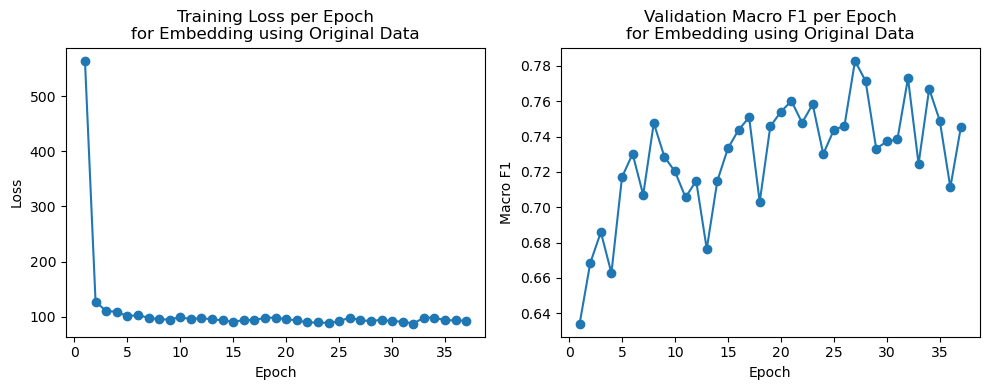

In [76]:
train_model_comp(model, train_loader, test_loader, 'Embedding', 'Original Data', num_epochs=100, lr=1e-3, save_path='embedding_model.pt')

In [26]:
model.load_state_dict(torch.load('embedding_model.pt'))
model.to(device) 

y_true, y_pred = test_with_classification_report(model, test_loader, idx2label)

              precision    recall  f1-score   support

        ctrl     0.9677    0.9859    0.9767       213
         gpt     0.9953    1.0000    0.9977       213
        gpt2     0.5302    0.6963    0.6020       214
      grover     0.6410    0.4695    0.5420       213
         xlm     0.9860    0.9953    0.9907       213
       xlnet     0.9904    0.9671    0.9786       213
        pplm     0.8776    0.6028    0.7147       214
       human     0.6783    0.7324    0.7043       213
        fair     0.4980    0.5869    0.5388       213

    accuracy                         0.7817      1919
   macro avg     0.7961    0.7818    0.7828      1919
weighted avg     0.7960    0.7817    0.7827      1919



# RNN (GRU)

In [27]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, embedding_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if embedding_weights is not None:
            self.embedding.weight.data.copy_(embedding_weights)
            self.embedding.weight.requires_grad = False  # freeze GloVe

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=False  # paper uses unidirectional GRU
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        embedded = self.embedding(x)  # [B, L, D]
        _, hidden = self.gru(embedded)  # hidden: [1, B, H]
        hidden = hidden.squeeze(0)     # [B, H]
        return self.classifier(hidden)


In [28]:
hidden_dim = 256

In [29]:
model = GRUClassifier(
    vocab_size=len(vocab),
    embedding_dim=300,
    hidden_dim=hidden_dim,
    num_classes=len(label2idx),
    embedding_weights=embedding_matrix
)

In [25]:
# train_model(model, train_loader, test_loader, num_epochs=10, lr=1e-3, save_path='rnn_model.pt')

Epoch 1/10: 100%|██████████| 120/120 [00:03<00:00, 31.79it/s]


Epoch 1, Loss: 218.1138, Val Macro F1: 0.4291
✅ Model saved.


Epoch 2/10: 100%|██████████| 120/120 [00:03<00:00, 35.00it/s]


Epoch 2, Loss: 127.8100, Val Macro F1: 0.6583
✅ Model saved.


Epoch 3/10: 100%|██████████| 120/120 [00:03<00:00, 34.96it/s]


Epoch 3, Loss: 80.8039, Val Macro F1: 0.7396
✅ Model saved.


Epoch 4/10: 100%|██████████| 120/120 [00:03<00:00, 34.88it/s]


Epoch 4, Loss: 66.2489, Val Macro F1: 0.7745
✅ Model saved.


Epoch 5/10: 100%|██████████| 120/120 [00:03<00:00, 34.85it/s]


Epoch 5, Loss: 58.6351, Val Macro F1: 0.7965
✅ Model saved.


Epoch 6/10: 100%|██████████| 120/120 [00:03<00:00, 34.97it/s]


Epoch 6, Loss: 53.0786, Val Macro F1: 0.8063
✅ Model saved.


Epoch 7/10: 100%|██████████| 120/120 [00:03<00:00, 34.97it/s]


Epoch 7, Loss: 46.6507, Val Macro F1: 0.8345
✅ Model saved.


Epoch 8/10: 100%|██████████| 120/120 [00:03<00:00, 34.88it/s]


Epoch 8, Loss: 44.4426, Val Macro F1: 0.8450
✅ Model saved.


Epoch 9/10: 100%|██████████| 120/120 [00:03<00:00, 35.01it/s]


Epoch 9, Loss: 36.5892, Val Macro F1: 0.8601
✅ Model saved.


Epoch 10/10: 100%|██████████| 120/120 [00:03<00:00, 34.96it/s]


Epoch 10, Loss: 31.8920, Val Macro F1: 0.8658
✅ Model saved.
✅ Training complete.


Epoch 1/100: 100%|██████████| 120/120 [00:03<00:00, 34.17it/s, loss=1.45]


Epoch 1, Loss: 219.8047, Val Macro F1: 0.3561
✅ Model saved.


Epoch 2/100: 100%|██████████| 120/120 [00:03<00:00, 34.51it/s, loss=0.856]


Epoch 2, Loss: 130.3027, Val Macro F1: 0.6999
✅ Model saved.


Epoch 3/100: 100%|██████████| 120/120 [00:03<00:00, 34.21it/s, loss=0.58] 


Epoch 3, Loss: 77.9220, Val Macro F1: 0.7516
✅ Model saved.


Epoch 4/100: 100%|██████████| 120/120 [00:03<00:00, 34.23it/s, loss=0.385]


Epoch 4, Loss: 62.6007, Val Macro F1: 0.7429


Epoch 5/100: 100%|██████████| 120/120 [00:03<00:00, 34.46it/s, loss=0.509]


Epoch 5, Loss: 56.8255, Val Macro F1: 0.7833
✅ Model saved.


Epoch 6/100: 100%|██████████| 120/120 [00:03<00:00, 33.99it/s, loss=0.593]


Epoch 6, Loss: 51.5868, Val Macro F1: 0.7849
✅ Model saved.


Epoch 7/100: 100%|██████████| 120/120 [00:03<00:00, 34.17it/s, loss=0.366]


Epoch 7, Loss: 46.3555, Val Macro F1: 0.8209
✅ Model saved.


Epoch 8/100: 100%|██████████| 120/120 [00:03<00:00, 34.23it/s, loss=0.315]


Epoch 8, Loss: 40.9381, Val Macro F1: 0.8386
✅ Model saved.


Epoch 9/100: 100%|██████████| 120/120 [00:03<00:00, 34.22it/s, loss=0.197]


Epoch 9, Loss: 34.9290, Val Macro F1: 0.8526
✅ Model saved.


Epoch 10/100: 100%|██████████| 120/120 [00:03<00:00, 34.23it/s, loss=0.277]


Epoch 10, Loss: 31.1617, Val Macro F1: 0.8387


Epoch 11/100: 100%|██████████| 120/120 [00:03<00:00, 34.40it/s, loss=0.326] 


Epoch 11, Loss: 25.2051, Val Macro F1: 0.8614
✅ Model saved.


Epoch 12/100: 100%|██████████| 120/120 [00:03<00:00, 34.28it/s, loss=0.288] 


Epoch 12, Loss: 21.8135, Val Macro F1: 0.8370


Epoch 13/100: 100%|██████████| 120/120 [00:03<00:00, 34.38it/s, loss=0.0788]


Epoch 13, Loss: 18.7700, Val Macro F1: 0.8584


Epoch 14/100: 100%|██████████| 120/120 [00:03<00:00, 34.30it/s, loss=0.042] 


Epoch 14, Loss: 12.3508, Val Macro F1: 0.8674
✅ Model saved.


Epoch 15/100: 100%|██████████| 120/120 [00:03<00:00, 34.32it/s, loss=0.0925] 


Epoch 15, Loss: 9.9592, Val Macro F1: 0.8779
✅ Model saved.


Epoch 16/100: 100%|██████████| 120/120 [00:03<00:00, 34.25it/s, loss=0.0179] 


Epoch 16, Loss: 7.7824, Val Macro F1: 0.8689


Epoch 17/100: 100%|██████████| 120/120 [00:03<00:00, 34.28it/s, loss=0.0519] 


Epoch 17, Loss: 6.4075, Val Macro F1: 0.8686


Epoch 18/100: 100%|██████████| 120/120 [00:03<00:00, 34.42it/s, loss=0.104]  


Epoch 18, Loss: 5.2720, Val Macro F1: 0.8653


Epoch 19/100: 100%|██████████| 120/120 [00:03<00:00, 34.31it/s, loss=0.0136] 


Epoch 19, Loss: 4.8563, Val Macro F1: 0.8737


Epoch 20/100: 100%|██████████| 120/120 [00:03<00:00, 34.22it/s, loss=0.0169]  


Epoch 20, Loss: 4.0294, Val Macro F1: 0.8648


Epoch 21/100: 100%|██████████| 120/120 [00:03<00:00, 34.32it/s, loss=0.0297] 


Epoch 21, Loss: 3.4888, Val Macro F1: 0.8785
✅ Model saved.


Epoch 22/100: 100%|██████████| 120/120 [00:03<00:00, 34.02it/s, loss=0.00554]


Epoch 22, Loss: 5.3971, Val Macro F1: 0.8761


Epoch 23/100: 100%|██████████| 120/120 [00:03<00:00, 33.99it/s, loss=0.0122] 


Epoch 23, Loss: 3.4836, Val Macro F1: 0.8719


Epoch 24/100: 100%|██████████| 120/120 [00:03<00:00, 34.24it/s, loss=0.0274] 


Epoch 24, Loss: 1.7496, Val Macro F1: 0.8702


Epoch 25/100: 100%|██████████| 120/120 [00:03<00:00, 34.22it/s, loss=0.00686] 


Epoch 25, Loss: 1.6319, Val Macro F1: 0.8714


Epoch 26/100: 100%|██████████| 120/120 [00:03<00:00, 34.30it/s, loss=0.00095] 


Epoch 26, Loss: 2.0406, Val Macro F1: 0.8434


Epoch 27/100: 100%|██████████| 120/120 [00:03<00:00, 34.31it/s, loss=0.0548] 


Epoch 27, Loss: 3.0418, Val Macro F1: 0.8680


Epoch 28/100: 100%|██████████| 120/120 [00:03<00:00, 34.37it/s, loss=0.00133]


Epoch 28, Loss: 2.7728, Val Macro F1: 0.8760


Epoch 29/100: 100%|██████████| 120/120 [00:03<00:00, 34.36it/s, loss=0.073]   


Epoch 29, Loss: 1.9143, Val Macro F1: 0.8704


Epoch 30/100: 100%|██████████| 120/120 [00:03<00:00, 34.36it/s, loss=0.000306]


Epoch 30, Loss: 0.8792, Val Macro F1: 0.8801
✅ Model saved.


Epoch 31/100: 100%|██████████| 120/120 [00:03<00:00, 34.17it/s, loss=0.0525] 


Epoch 31, Loss: 3.1684, Val Macro F1: 0.8643


Epoch 32/100: 100%|██████████| 120/120 [00:03<00:00, 34.16it/s, loss=0.00184]


Epoch 32, Loss: 3.2006, Val Macro F1: 0.8704


Epoch 33/100: 100%|██████████| 120/120 [00:03<00:00, 33.81it/s, loss=0.00123] 


Epoch 33, Loss: 1.8619, Val Macro F1: 0.8767


Epoch 34/100: 100%|██████████| 120/120 [00:03<00:00, 34.28it/s, loss=0.102]   


Epoch 34, Loss: 0.5406, Val Macro F1: 0.8732


Epoch 35/100: 100%|██████████| 120/120 [00:03<00:00, 34.32it/s, loss=0.000152]


Epoch 35, Loss: 0.1865, Val Macro F1: 0.8747


Epoch 36/100: 100%|██████████| 120/120 [00:03<00:00, 34.32it/s, loss=0.000941]


Epoch 36, Loss: 0.0493, Val Macro F1: 0.8743


Epoch 37/100: 100%|██████████| 120/120 [00:03<00:00, 34.23it/s, loss=0.000126]


Epoch 37, Loss: 0.0469, Val Macro F1: 0.8748


Epoch 38/100: 100%|██████████| 120/120 [00:03<00:00, 34.31it/s, loss=6.61e-5] 


Epoch 38, Loss: 0.0270, Val Macro F1: 0.8738


Epoch 39/100: 100%|██████████| 120/120 [00:03<00:00, 34.11it/s, loss=0.000408]


Epoch 39, Loss: 0.0227, Val Macro F1: 0.8726


Epoch 40/100: 100%|██████████| 120/120 [00:03<00:00, 34.04it/s, loss=0.000155]


Epoch 40, Loss: 0.0171, Val Macro F1: 0.8756
⏹️ Early stopping triggered.
✅ Training complete.


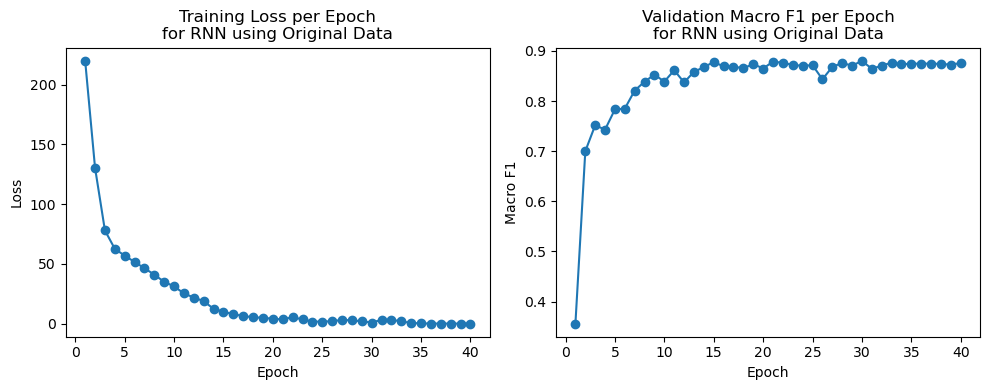

In [81]:
train_model_comp(model, train_loader, test_loader, 'RNN', 'Original Data', num_epochs=100, lr=1e-3, save_path='rnn_model.pt')

In [32]:
model.load_state_dict(torch.load('rnn_model.pt'))
model.to(device)

y_true, y_pred = test_with_classification_report(model, test_loader, idx2label)


              precision    recall  f1-score   support

        ctrl     0.9953    0.9953    0.9953       213
         gpt     0.9953    0.9953    0.9953       213
        gpt2     0.7215    0.7383    0.7298       214
      grover     0.7455    0.7840    0.7643       213
         xlm     1.0000    0.9953    0.9976       213
       xlnet     0.9953    1.0000    0.9977       213
        pplm     0.8531    0.8411    0.8471       214
       human     0.8607    0.8122    0.8357       213
        fair     0.7594    0.7559    0.7576       213

    accuracy                         0.8796      1919
   macro avg     0.8807    0.8797    0.8801      1919
weighted avg     0.8806    0.8796    0.8800      1919



# Stacked CNN

In [33]:
class StackedCNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, embedding_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if embedding_weights is not None:
            self.embedding.weight.data.copy_(embedding_weights)
            self.embedding.weight.requires_grad = False  # freeze GloVe

        self.conv_stack = nn.Sequential(
            nn.Conv1d(embedding_dim, 256, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3),
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)  # [B, C, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        embedded = self.embedding(x)         # [B, L, D]
        x = embedded.permute(0, 2, 1)        # [B, D, L] for Conv1d
        x = self.conv_stack(x)              # [B, 256, 1]
        return self.classifier(x)


In [34]:
model = StackedCNNClassifier(
    vocab_size=len(vocab),
    embedding_dim=300,
    num_classes=len(label2idx),
    embedding_weights=embedding_matrix
)

In [29]:
# train_model(model, train_loader, test_loader, num_epochs=10, lr=1e-3, save_path='stacked_cnn_model.pt')

Epoch 1/10: 100%|██████████| 120/120 [00:03<00:00, 32.97it/s]


Epoch 1, Loss: 232.0208, Val Macro F1: 0.2870
✅ Model saved.


Epoch 2/10: 100%|██████████| 120/120 [00:02<00:00, 50.39it/s]


Epoch 2, Loss: 144.4205, Val Macro F1: 0.6589
✅ Model saved.


Epoch 3/10: 100%|██████████| 120/120 [00:02<00:00, 50.50it/s]


Epoch 3, Loss: 90.1784, Val Macro F1: 0.7415
✅ Model saved.


Epoch 4/10: 100%|██████████| 120/120 [00:02<00:00, 50.46it/s]


Epoch 4, Loss: 71.2825, Val Macro F1: 0.7396


Epoch 5/10: 100%|██████████| 120/120 [00:02<00:00, 50.19it/s]


Epoch 5, Loss: 62.0398, Val Macro F1: 0.7823
✅ Model saved.


Epoch 6/10: 100%|██████████| 120/120 [00:02<00:00, 50.42it/s]


Epoch 6, Loss: 49.7477, Val Macro F1: 0.7714


Epoch 7/10: 100%|██████████| 120/120 [00:02<00:00, 50.52it/s]


Epoch 7, Loss: 40.1096, Val Macro F1: 0.8158
✅ Model saved.


Epoch 8/10: 100%|██████████| 120/120 [00:02<00:00, 50.26it/s]


Epoch 8, Loss: 34.1912, Val Macro F1: 0.8113


Epoch 9/10: 100%|██████████| 120/120 [00:02<00:00, 50.28it/s]


Epoch 9, Loss: 27.6502, Val Macro F1: 0.8104
⏹️ Early stopping triggered.
✅ Training complete.


Epoch 1/100: 100%|██████████| 120/120 [00:02<00:00, 48.41it/s, loss=1.1]  


Epoch 1, Loss: 186.5308, Val Macro F1: 0.5626
✅ Model saved.


Epoch 2/100: 100%|██████████| 120/120 [00:02<00:00, 48.02it/s, loss=0.82] 


Epoch 2, Loss: 110.1955, Val Macro F1: 0.6059
✅ Model saved.


Epoch 3/100: 100%|██████████| 120/120 [00:02<00:00, 48.35it/s, loss=0.76] 


Epoch 3, Loss: 97.5542, Val Macro F1: 0.6930
✅ Model saved.


Epoch 4/100: 100%|██████████| 120/120 [00:02<00:00, 48.41it/s, loss=0.727]


Epoch 4, Loss: 79.6092, Val Macro F1: 0.7534
✅ Model saved.


Epoch 5/100: 100%|██████████| 120/120 [00:02<00:00, 47.54it/s, loss=0.433]


Epoch 5, Loss: 67.8337, Val Macro F1: 0.7606
✅ Model saved.


Epoch 6/100: 100%|██████████| 120/120 [00:02<00:00, 48.48it/s, loss=0.829]


Epoch 6, Loss: 57.1154, Val Macro F1: 0.7741
✅ Model saved.


Epoch 7/100: 100%|██████████| 120/120 [00:02<00:00, 48.44it/s, loss=0.256]


Epoch 7, Loss: 47.9256, Val Macro F1: 0.7948
✅ Model saved.


Epoch 8/100: 100%|██████████| 120/120 [00:02<00:00, 48.06it/s, loss=0.321]


Epoch 8, Loss: 39.9104, Val Macro F1: 0.8032
✅ Model saved.


Epoch 9/100: 100%|██████████| 120/120 [00:02<00:00, 48.36it/s, loss=0.281]


Epoch 9, Loss: 37.2892, Val Macro F1: 0.7717


Epoch 10/100: 100%|██████████| 120/120 [00:02<00:00, 48.34it/s, loss=0.151] 


Epoch 10, Loss: 28.5048, Val Macro F1: 0.8208
✅ Model saved.


Epoch 11/100: 100%|██████████| 120/120 [00:02<00:00, 47.72it/s, loss=0.234]


Epoch 11, Loss: 25.3838, Val Macro F1: 0.8162


Epoch 12/100: 100%|██████████| 120/120 [00:02<00:00, 47.73it/s, loss=0.0915]


Epoch 12, Loss: 15.1062, Val Macro F1: 0.8225
✅ Model saved.


Epoch 13/100: 100%|██████████| 120/120 [00:02<00:00, 48.04it/s, loss=0.179] 


Epoch 13, Loss: 16.6543, Val Macro F1: 0.7918


Epoch 14/100: 100%|██████████| 120/120 [00:02<00:00, 48.42it/s, loss=0.37]  


Epoch 14, Loss: 14.7273, Val Macro F1: 0.8233
✅ Model saved.


Epoch 15/100: 100%|██████████| 120/120 [00:02<00:00, 48.04it/s, loss=0.213] 


Epoch 15, Loss: 12.9598, Val Macro F1: 0.8367
✅ Model saved.


Epoch 16/100: 100%|██████████| 120/120 [00:02<00:00, 48.05it/s, loss=0.0508]


Epoch 16, Loss: 9.6310, Val Macro F1: 0.8320


Epoch 17/100: 100%|██████████| 120/120 [00:02<00:00, 48.65it/s, loss=0.0202]


Epoch 17, Loss: 7.7269, Val Macro F1: 0.8360


Epoch 18/100: 100%|██████████| 120/120 [00:02<00:00, 48.04it/s, loss=0.0493] 


Epoch 18, Loss: 7.6116, Val Macro F1: 0.8187


Epoch 19/100: 100%|██████████| 120/120 [00:02<00:00, 48.28it/s, loss=0.0395] 


Epoch 19, Loss: 11.9299, Val Macro F1: 0.8193


Epoch 20/100: 100%|██████████| 120/120 [00:02<00:00, 48.33it/s, loss=0.077] 


Epoch 20, Loss: 9.2187, Val Macro F1: 0.8303


Epoch 21/100: 100%|██████████| 120/120 [00:02<00:00, 48.27it/s, loss=0.00528]


Epoch 21, Loss: 7.5164, Val Macro F1: 0.8091


Epoch 22/100: 100%|██████████| 120/120 [00:02<00:00, 48.36it/s, loss=0.0376]


Epoch 22, Loss: 8.8430, Val Macro F1: 0.8197


Epoch 23/100: 100%|██████████| 120/120 [00:02<00:00, 48.25it/s, loss=0.00426] 


Epoch 23, Loss: 5.2943, Val Macro F1: 0.8256


Epoch 24/100: 100%|██████████| 120/120 [00:02<00:00, 48.52it/s, loss=0.0573] 


Epoch 24, Loss: 7.3527, Val Macro F1: 0.8109


Epoch 25/100: 100%|██████████| 120/120 [00:02<00:00, 48.70it/s, loss=0.206]  


Epoch 25, Loss: 7.1049, Val Macro F1: 0.8030
⏹️ Early stopping triggered.
✅ Training complete.


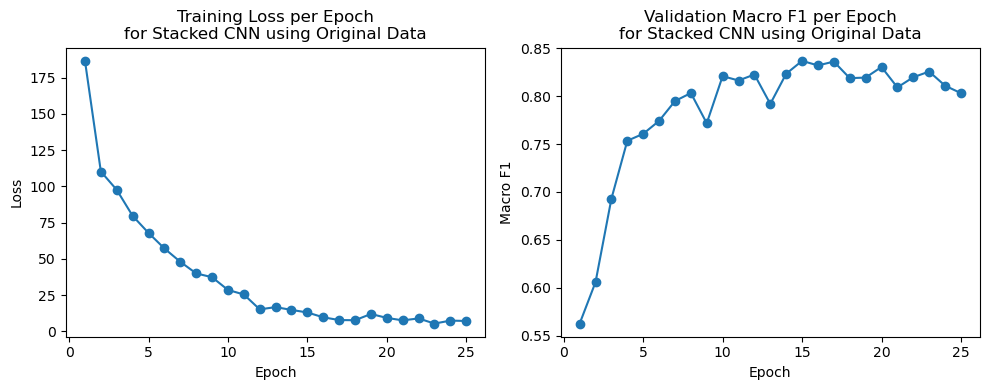

In [85]:
train_model_comp(model, train_loader, test_loader, 'Stacked CNN', 'Original Data', num_epochs=100, lr=1e-3, save_path='stacked_cnn_model.pt')

In [35]:
model.load_state_dict(torch.load('stacked_cnn_model.pt'))
model.to(device)

y_true, y_pred = test_with_classification_report(model, test_loader, idx2label)


              precision    recall  f1-score   support

        ctrl     0.9674    0.9765    0.9720       213
         gpt     0.9860    0.9953    0.9907       213
        gpt2     0.5776    0.7477    0.6517       214
      grover     0.6641    0.7981    0.7249       213
         xlm     0.9905    0.9812    0.9858       213
       xlnet     1.0000    0.9906    0.9953       213
        pplm     0.8342    0.7523    0.7912       214
       human     0.9101    0.7606    0.8286       213
        fair     0.6810    0.5211    0.5904       213

    accuracy                         0.8359      1919
   macro avg     0.8457    0.8359    0.8367      1919
weighted avg     0.8455    0.8359    0.8366      1919



# Parallel CNN

In [36]:
class ParallelCNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, embedding_weights=None, kernel_sizes=[2, 3, 4, 5], num_filters=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if embedding_weights is not None:
            self.embedding.weight.data.copy_(embedding_weights)
            self.embedding.weight.requires_grad = False  # freeze GloVe

        # Parallel conv layers
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k),
                nn.ReLU(),
                nn.AdaptiveMaxPool1d(1)
            ) for k in kernel_sizes
        ])

        self.classifier = nn.Sequential(
            nn.Linear(num_filters * len(kernel_sizes), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        embedded = self.embedding(x)      # [B, L, D]
        embedded = embedded.permute(0, 2, 1)  # [B, D, L]
        features = [conv(embedded).squeeze(2) for conv in self.convs]  # [B, F]
        concat = torch.cat(features, dim=1)  # [B, F * num_kernels]
        return self.classifier(concat)


In [37]:
model = ParallelCNNClassifier(
    vocab_size=len(vocab),
    embedding_dim=300,
    num_classes=len(label2idx),
    embedding_weights=embedding_matrix
)

In [33]:
# train_model(model, train_loader, test_loader, num_epochs=10, lr=1e-3, save_path='parallel_cnn_model.pt')

Epoch 1/10: 100%|██████████| 120/120 [00:02<00:00, 43.63it/s]


Epoch 1, Loss: 140.9045, Val Macro F1: 0.7449
✅ Model saved.


Epoch 2/10: 100%|██████████| 120/120 [00:02<00:00, 44.82it/s]


Epoch 2, Loss: 71.0198, Val Macro F1: 0.8180
✅ Model saved.


Epoch 3/10: 100%|██████████| 120/120 [00:02<00:00, 44.94it/s]


Epoch 3, Loss: 51.1253, Val Macro F1: 0.8291
✅ Model saved.


Epoch 4/10: 100%|██████████| 120/120 [00:02<00:00, 44.84it/s]


Epoch 4, Loss: 33.1667, Val Macro F1: 0.8551
✅ Model saved.


Epoch 5/10: 100%|██████████| 120/120 [00:02<00:00, 44.75it/s]


Epoch 5, Loss: 19.3515, Val Macro F1: 0.8684
✅ Model saved.


Epoch 6/10: 100%|██████████| 120/120 [00:02<00:00, 44.89it/s]


Epoch 6, Loss: 10.0375, Val Macro F1: 0.8702
✅ Model saved.


Epoch 7/10: 100%|██████████| 120/120 [00:02<00:00, 45.03it/s]


Epoch 7, Loss: 5.1085, Val Macro F1: 0.8697


Epoch 8/10: 100%|██████████| 120/120 [00:02<00:00, 45.01it/s]


Epoch 8, Loss: 4.7297, Val Macro F1: 0.8670
⏹️ Early stopping triggered.
✅ Training complete.


Epoch 1/100: 100%|██████████| 120/120 [00:02<00:00, 42.95it/s, loss=0.767]


Epoch 1, Loss: 142.8339, Val Macro F1: 0.7682
✅ Model saved.


Epoch 2/100: 100%|██████████| 120/120 [00:02<00:00, 41.46it/s, loss=0.628]


Epoch 2, Loss: 73.3691, Val Macro F1: 0.7969
✅ Model saved.


Epoch 3/100: 100%|██████████| 120/120 [00:02<00:00, 41.17it/s, loss=0.632]


Epoch 3, Loss: 52.6902, Val Macro F1: 0.8384
✅ Model saved.


Epoch 4/100: 100%|██████████| 120/120 [00:02<00:00, 42.74it/s, loss=0.237]


Epoch 4, Loss: 34.4896, Val Macro F1: 0.8484
✅ Model saved.


Epoch 5/100: 100%|██████████| 120/120 [00:02<00:00, 43.06it/s, loss=0.121] 


Epoch 5, Loss: 20.3044, Val Macro F1: 0.8611
✅ Model saved.


Epoch 6/100: 100%|██████████| 120/120 [00:02<00:00, 42.94it/s, loss=0.122] 


Epoch 6, Loss: 9.7278, Val Macro F1: 0.8710
✅ Model saved.


Epoch 7/100: 100%|██████████| 120/120 [00:02<00:00, 43.27it/s, loss=0.0161] 


Epoch 7, Loss: 5.0552, Val Macro F1: 0.8681


Epoch 8/100: 100%|██████████| 120/120 [00:02<00:00, 42.74it/s, loss=0.0157] 


Epoch 8, Loss: 3.0017, Val Macro F1: 0.8679


Epoch 9/100: 100%|██████████| 120/120 [00:02<00:00, 42.51it/s, loss=0.00496]


Epoch 9, Loss: 2.2973, Val Macro F1: 0.8664


Epoch 10/100: 100%|██████████| 120/120 [00:02<00:00, 41.46it/s, loss=0.0479] 


Epoch 10, Loss: 1.5407, Val Macro F1: 0.8644


Epoch 11/100: 100%|██████████| 120/120 [00:02<00:00, 42.05it/s, loss=0.00404]


Epoch 11, Loss: 1.1206, Val Macro F1: 0.8765
✅ Model saved.


Epoch 12/100: 100%|██████████| 120/120 [00:02<00:00, 41.86it/s, loss=0.00387]


Epoch 12, Loss: 0.7708, Val Macro F1: 0.8772
✅ Model saved.


Epoch 13/100: 100%|██████████| 120/120 [00:02<00:00, 43.08it/s, loss=0.00315] 


Epoch 13, Loss: 0.6891, Val Macro F1: 0.8753


Epoch 14/100: 100%|██████████| 120/120 [00:02<00:00, 42.92it/s, loss=0.0025]  


Epoch 14, Loss: 0.4782, Val Macro F1: 0.8689


Epoch 15/100: 100%|██████████| 120/120 [00:02<00:00, 43.09it/s, loss=0.0647] 


Epoch 15, Loss: 0.8331, Val Macro F1: 0.8462


Epoch 16/100: 100%|██████████| 120/120 [00:02<00:00, 43.18it/s, loss=0.0355] 


Epoch 16, Loss: 1.6461, Val Macro F1: 0.8613


Epoch 17/100: 100%|██████████| 120/120 [00:02<00:00, 43.20it/s, loss=0.0379]


Epoch 17, Loss: 5.7740, Val Macro F1: 0.8483


Epoch 18/100: 100%|██████████| 120/120 [00:02<00:00, 42.70it/s, loss=0.154] 


Epoch 18, Loss: 8.2520, Val Macro F1: 0.8547


Epoch 19/100: 100%|██████████| 120/120 [00:02<00:00, 41.66it/s, loss=0.036]  


Epoch 19, Loss: 3.4365, Val Macro F1: 0.8558


Epoch 20/100: 100%|██████████| 120/120 [00:02<00:00, 42.28it/s, loss=0.0077] 


Epoch 20, Loss: 2.1763, Val Macro F1: 0.8618


Epoch 21/100: 100%|██████████| 120/120 [00:02<00:00, 41.00it/s, loss=0.00368] 


Epoch 21, Loss: 1.2297, Val Macro F1: 0.8684


Epoch 22/100: 100%|██████████| 120/120 [00:02<00:00, 41.65it/s, loss=0.00119] 


Epoch 22, Loss: 0.7691, Val Macro F1: 0.8708
⏹️ Early stopping triggered.
✅ Training complete.


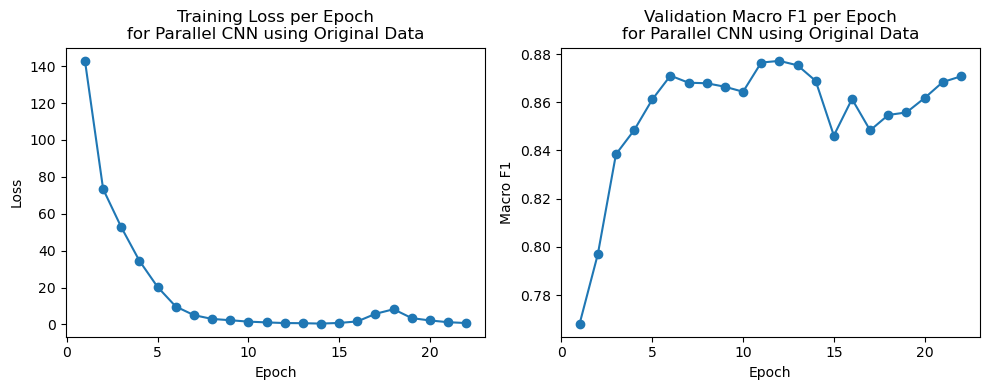

In [89]:
train_model_comp(model, train_loader, test_loader, 'Parallel CNN', 'Original Data', num_epochs=100, lr=1e-3, save_path='parallel_cnn_model.pt')

In [38]:
model.load_state_dict(torch.load('parallel_cnn_model.pt'))
model.to(device)

y_true, y_pred = test_with_classification_report(model, test_loader, idx2label)


              precision    recall  f1-score   support

        ctrl     0.9953    0.9953    0.9953       213
         gpt     1.0000    0.9953    0.9976       213
        gpt2     0.7072    0.7336    0.7202       214
      grover     0.7840    0.7840    0.7840       213
         xlm     0.9907    1.0000    0.9953       213
       xlnet     1.0000    0.9953    0.9976       213
        pplm     0.8641    0.8318    0.8476       214
       human     0.9010    0.8122    0.8543       213
        fair     0.6709    0.7371    0.7025       213

    accuracy                         0.8760      1919
   macro avg     0.8793    0.8761    0.8772      1919
weighted avg     0.8792    0.8760    0.8771      1919



# CNN-RNN Hybrid

In [39]:
class CNNRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, embedding_weights=None, cnn_kernel_size=3, rnn_hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if embedding_weights is not None:
            self.embedding.weight.data.copy_(embedding_weights)
            self.embedding.weight.requires_grad = False  # freeze GloVe

        self.cnn = nn.Sequential(
            nn.Conv1d(embedding_dim, 256, kernel_size=cnn_kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.gru = nn.GRU(
            input_size=256,
            hidden_size=rnn_hidden_dim,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)             # [B, L, D]
        x = x.permute(0, 2, 1)            # [B, D, L]
        x = self.cnn(x)                   # [B, 256, L]
        x = x.permute(0, 2, 1)            # [B, L, 256]
        _, hidden = self.gru(x)          # [1, B, H]
        hidden = hidden.squeeze(0)       # [B, H]
        return self.classifier(hidden)


In [40]:
model = CNNRNNClassifier(
    vocab_size=len(vocab),
    embedding_dim=300,
    num_classes=len(label2idx),
    embedding_weights=embedding_matrix
)

In [37]:
# train_model(model, train_loader, test_loader, num_epochs=10, lr=1e-3, save_path='cnn_rnn_model.pt')

Epoch 1/10: 100%|██████████| 120/120 [00:03<00:00, 30.24it/s]


Epoch 1, Loss: 227.0656, Val Macro F1: 0.3798
✅ Model saved.


Epoch 2/10: 100%|██████████| 120/120 [00:03<00:00, 30.17it/s]


Epoch 2, Loss: 132.3675, Val Macro F1: 0.7036
✅ Model saved.


Epoch 3/10: 100%|██████████| 120/120 [00:03<00:00, 30.16it/s]


Epoch 3, Loss: 76.3766, Val Macro F1: 0.7560
✅ Model saved.


Epoch 4/10: 100%|██████████| 120/120 [00:03<00:00, 30.18it/s]


Epoch 4, Loss: 66.3945, Val Macro F1: 0.7590
✅ Model saved.


Epoch 5/10: 100%|██████████| 120/120 [00:03<00:00, 30.18it/s]


Epoch 5, Loss: 55.1054, Val Macro F1: 0.7971
✅ Model saved.


Epoch 6/10: 100%|██████████| 120/120 [00:03<00:00, 30.30it/s]


Epoch 6, Loss: 49.6157, Val Macro F1: 0.8254
✅ Model saved.


Epoch 7/10: 100%|██████████| 120/120 [00:03<00:00, 30.26it/s]


Epoch 7, Loss: 42.7977, Val Macro F1: 0.8414
✅ Model saved.


Epoch 8/10: 100%|██████████| 120/120 [00:03<00:00, 30.20it/s]


Epoch 8, Loss: 37.5511, Val Macro F1: 0.8358


Epoch 9/10: 100%|██████████| 120/120 [00:03<00:00, 30.12it/s]


Epoch 9, Loss: 32.7388, Val Macro F1: 0.8447
✅ Model saved.


Epoch 10/10: 100%|██████████| 120/120 [00:03<00:00, 30.12it/s]


Epoch 10, Loss: 25.8664, Val Macro F1: 0.8497
✅ Model saved.
✅ Training complete.


Epoch 1/100: 100%|██████████| 120/120 [00:04<00:00, 29.69it/s, loss=1.56]


Epoch 1, Loss: 221.3523, Val Macro F1: 0.3274
✅ Model saved.


Epoch 2/100: 100%|██████████| 120/120 [00:04<00:00, 29.76it/s, loss=0.617]


Epoch 2, Loss: 122.4976, Val Macro F1: 0.6382
✅ Model saved.


Epoch 3/100: 100%|██████████| 120/120 [00:04<00:00, 29.70it/s, loss=0.703]


Epoch 3, Loss: 77.1477, Val Macro F1: 0.6955
✅ Model saved.


Epoch 4/100: 100%|██████████| 120/120 [00:04<00:00, 29.70it/s, loss=0.383]


Epoch 4, Loss: 65.4655, Val Macro F1: 0.7925
✅ Model saved.


Epoch 5/100: 100%|██████████| 120/120 [00:04<00:00, 29.49it/s, loss=0.541]


Epoch 5, Loss: 56.6044, Val Macro F1: 0.7915


Epoch 6/100: 100%|██████████| 120/120 [00:04<00:00, 29.61it/s, loss=0.377]


Epoch 6, Loss: 48.8196, Val Macro F1: 0.8169
✅ Model saved.


Epoch 7/100: 100%|██████████| 120/120 [00:04<00:00, 29.57it/s, loss=0.365]


Epoch 7, Loss: 43.2435, Val Macro F1: 0.8259
✅ Model saved.


Epoch 8/100: 100%|██████████| 120/120 [00:04<00:00, 29.67it/s, loss=0.23] 


Epoch 8, Loss: 35.5488, Val Macro F1: 0.8104


Epoch 9/100: 100%|██████████| 120/120 [00:04<00:00, 29.77it/s, loss=0.104]


Epoch 9, Loss: 29.7287, Val Macro F1: 0.8197


Epoch 10/100: 100%|██████████| 120/120 [00:04<00:00, 29.69it/s, loss=0.304] 


Epoch 10, Loss: 23.9150, Val Macro F1: 0.8201


Epoch 11/100: 100%|██████████| 120/120 [00:04<00:00, 29.71it/s, loss=0.0875]


Epoch 11, Loss: 20.7839, Val Macro F1: 0.8309
✅ Model saved.


Epoch 12/100: 100%|██████████| 120/120 [00:04<00:00, 29.64it/s, loss=0.0866]


Epoch 12, Loss: 16.6248, Val Macro F1: 0.8358
✅ Model saved.


Epoch 13/100: 100%|██████████| 120/120 [00:04<00:00, 29.61it/s, loss=0.169] 


Epoch 13, Loss: 12.4766, Val Macro F1: 0.8490
✅ Model saved.


Epoch 14/100: 100%|██████████| 120/120 [00:04<00:00, 29.67it/s, loss=0.0435]


Epoch 14, Loss: 14.6563, Val Macro F1: 0.8401


Epoch 15/100: 100%|██████████| 120/120 [00:04<00:00, 29.67it/s, loss=0.152] 


Epoch 15, Loss: 8.9535, Val Macro F1: 0.8403


Epoch 16/100: 100%|██████████| 120/120 [00:04<00:00, 29.70it/s, loss=0.025]  


Epoch 16, Loss: 7.7510, Val Macro F1: 0.8375


Epoch 17/100: 100%|██████████| 120/120 [00:04<00:00, 29.79it/s, loss=0.0867]


Epoch 17, Loss: 8.7840, Val Macro F1: 0.8425


Epoch 18/100: 100%|██████████| 120/120 [00:04<00:00, 29.67it/s, loss=0.129]  


Epoch 18, Loss: 4.6671, Val Macro F1: 0.8411


Epoch 19/100: 100%|██████████| 120/120 [00:04<00:00, 29.60it/s, loss=0.0528] 


Epoch 19, Loss: 5.0564, Val Macro F1: 0.8441


Epoch 20/100: 100%|██████████| 120/120 [00:04<00:00, 29.64it/s, loss=0.0198] 


Epoch 20, Loss: 4.9605, Val Macro F1: 0.8414


Epoch 21/100: 100%|██████████| 120/120 [00:04<00:00, 29.74it/s, loss=0.0176] 


Epoch 21, Loss: 4.9991, Val Macro F1: 0.8468


Epoch 22/100: 100%|██████████| 120/120 [00:04<00:00, 29.78it/s, loss=0.17]   


Epoch 22, Loss: 3.6339, Val Macro F1: 0.8277


Epoch 23/100: 100%|██████████| 120/120 [00:04<00:00, 29.76it/s, loss=0.00455]


Epoch 23, Loss: 4.4330, Val Macro F1: 0.8463
⏹️ Early stopping triggered.
✅ Training complete.


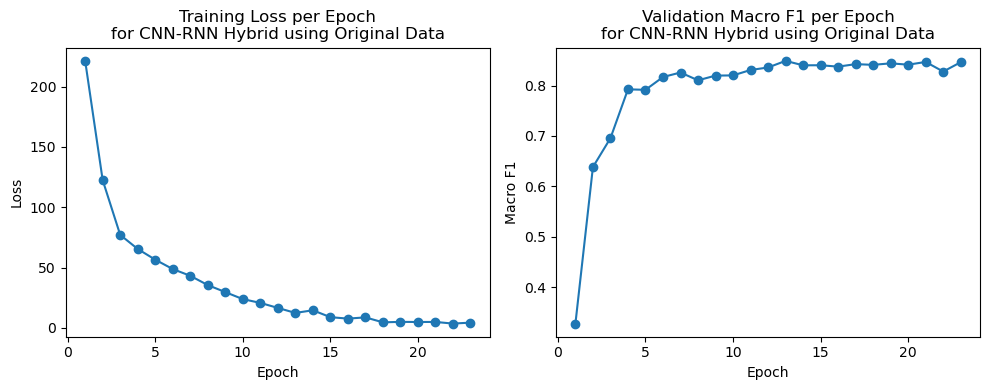

In [93]:
train_model_comp(model, train_loader, test_loader, 'CNN-RNN Hybrid', 'Original Data', num_epochs=100, lr=1e-3, save_path='cnn_rnn_model.pt')

In [41]:
model.load_state_dict(torch.load('cnn_rnn_model.pt'))
model.to(device)

y_true, y_pred = test_with_classification_report(model, test_loader, idx2label)


              precision    recall  f1-score   support

        ctrl     0.9861    1.0000    0.9930       213
         gpt     0.9953    0.9953    0.9953       213
        gpt2     0.6735    0.7710    0.7190       214
      grover     0.6596    0.7277    0.6920       213
         xlm     1.0000    0.9953    0.9976       213
       xlnet     1.0000    1.0000    1.0000       213
        pplm     0.8703    0.7523    0.8070       214
       human     0.8476    0.6526    0.7374       213
        fair     0.6653    0.7371    0.6993       213

    accuracy                         0.8478      1919
   macro avg     0.8553    0.8479    0.8490      1919
weighted avg     0.8552    0.8478    0.8489      1919



# Visualizations

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [43]:
def plot_macro_f1_comparison(f1_scores):
    model_names = list(f1_scores.keys())
    scores = list(f1_scores.values())

    plt.figure(figsize=(10, 5))
    bars = plt.bar(model_names, scores)
    plt.ylim(0, 1.05)
    plt.ylabel("Macro F1 Score")
    plt.title("Macro F1 Score Comparison")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{score:.4f}", ha='center')

    plt.tight_layout()
    plt.show()


In [44]:
model_info = {
    "Embedding": EmbeddingClassifier(vocab_size=len(vocab),
                                     embedding_dim=embedding_dim,
                                     num_classes=num_classes,
                                     embedding_weights=embedding_matrix),
    
    "RNN (GRU)": GRUClassifier(vocab_size=len(vocab),
                               embedding_dim=300,
                               hidden_dim=hidden_dim,
                               num_classes=len(label2idx),
                               embedding_weights=embedding_matrix),
    
    "Stacked CNN": StackedCNNClassifier(vocab_size=len(vocab),
                                        embedding_dim=300,
                                        num_classes=len(label2idx),
                                        embedding_weights=embedding_matrix),
    
    "Parallel CNN": ParallelCNNClassifier(vocab_size=len(vocab),
                                          embedding_dim=300,
                                          num_classes=len(label2idx),
                                          embedding_weights=embedding_matrix),
    
    "CNN-RNN Hybrid": CNNRNNClassifier(vocab_size=len(vocab),
                                       embedding_dim=300,
                                       num_classes=len(label2idx),
                                       embedding_weights=embedding_matrix)
}


🔍 Evaluating: Embedding

📋 Classification Report for Embedding:

              precision    recall  f1-score   support

        ctrl     0.9677    0.9859    0.9767       213
        fair     0.4980    0.5869    0.5388       213
         gpt     0.9953    1.0000    0.9977       213
        gpt2     0.5302    0.6963    0.6020       214
      grover     0.6410    0.4695    0.5420       213
       human     0.6783    0.7324    0.7043       213
        pplm     0.8776    0.6028    0.7147       214
         xlm     0.9860    0.9953    0.9907       213
       xlnet     0.9904    0.9671    0.9786       213

    accuracy                         0.7817      1919
   macro avg     0.7961    0.7818    0.7828      1919
weighted avg     0.7960    0.7817    0.7827      1919



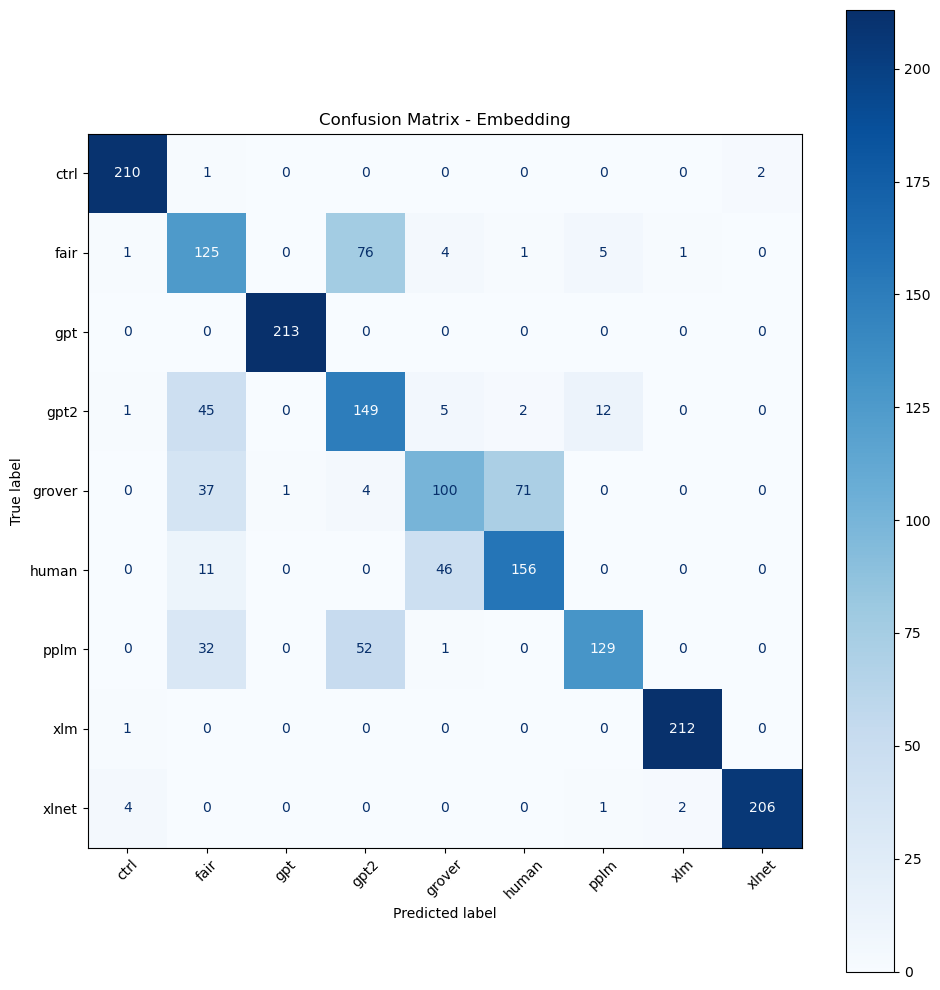


🔍 Evaluating: RNN (GRU)

📋 Classification Report for RNN (GRU):

              precision    recall  f1-score   support

        ctrl     0.9953    0.9953    0.9953       213
        fair     0.7594    0.7559    0.7576       213
         gpt     0.9953    0.9953    0.9953       213
        gpt2     0.7215    0.7383    0.7298       214
      grover     0.7455    0.7840    0.7643       213
       human     0.8607    0.8122    0.8357       213
        pplm     0.8531    0.8411    0.8471       214
         xlm     1.0000    0.9953    0.9976       213
       xlnet     0.9953    1.0000    0.9977       213

    accuracy                         0.8796      1919
   macro avg     0.8807    0.8797    0.8801      1919
weighted avg     0.8806    0.8796    0.8800      1919



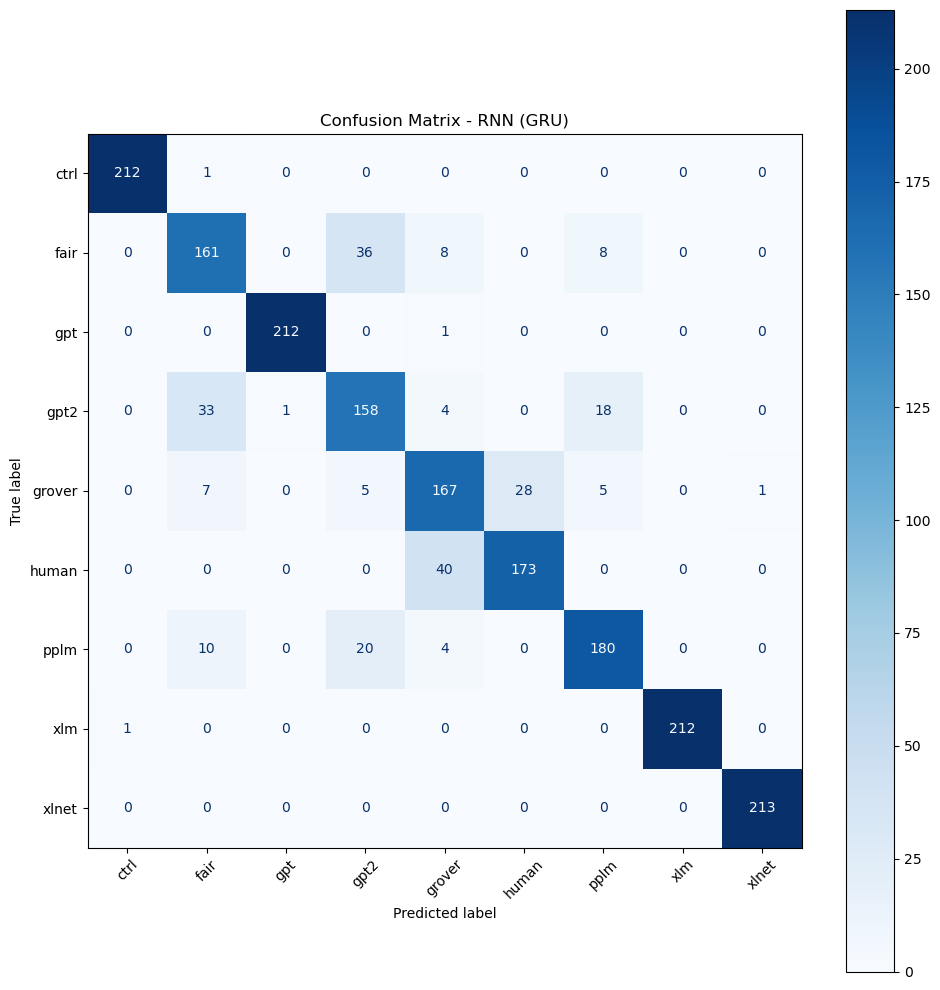


🔍 Evaluating: Stacked CNN

📋 Classification Report for Stacked CNN:

              precision    recall  f1-score   support

        ctrl     0.9674    0.9765    0.9720       213
        fair     0.6810    0.5211    0.5904       213
         gpt     0.9860    0.9953    0.9907       213
        gpt2     0.5776    0.7477    0.6517       214
      grover     0.6641    0.7981    0.7249       213
       human     0.9101    0.7606    0.8286       213
        pplm     0.8342    0.7523    0.7912       214
         xlm     0.9905    0.9812    0.9858       213
       xlnet     1.0000    0.9906    0.9953       213

    accuracy                         0.8359      1919
   macro avg     0.8457    0.8359    0.8367      1919
weighted avg     0.8455    0.8359    0.8366      1919



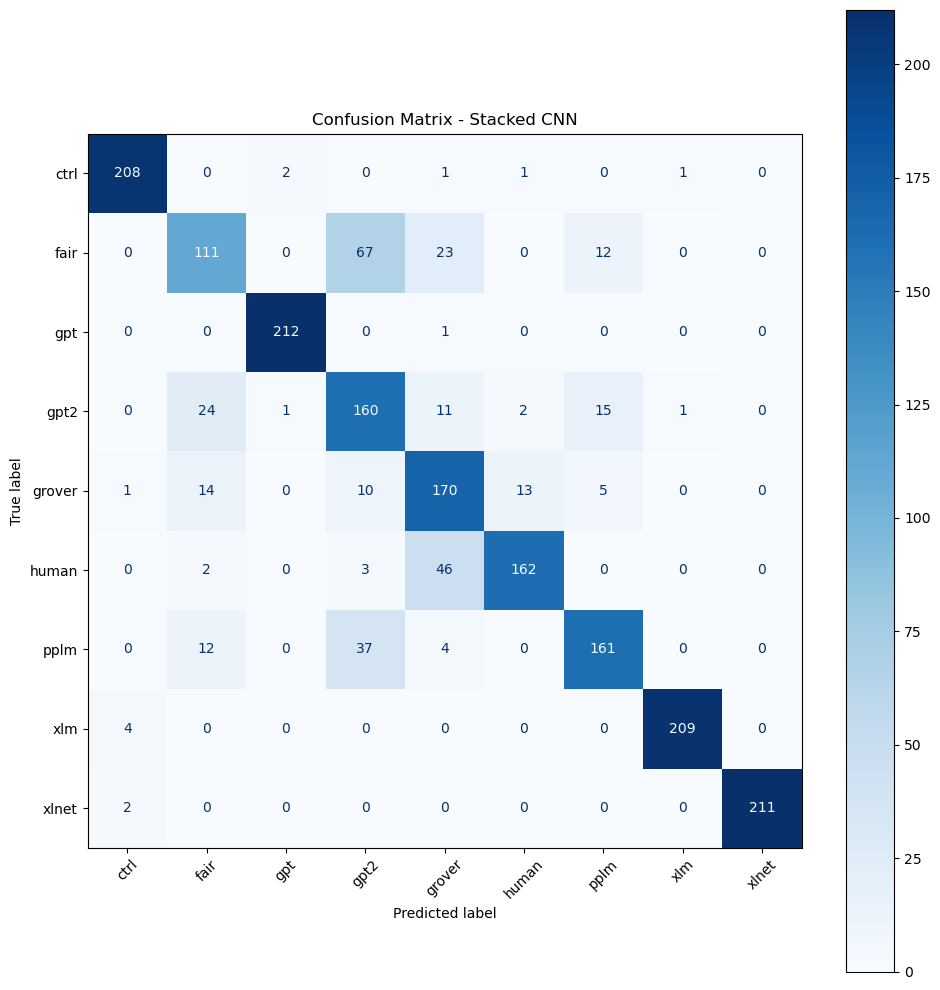


🔍 Evaluating: Parallel CNN

📋 Classification Report for Parallel CNN:

              precision    recall  f1-score   support

        ctrl     0.9953    0.9953    0.9953       213
        fair     0.6709    0.7371    0.7025       213
         gpt     1.0000    0.9953    0.9976       213
        gpt2     0.7072    0.7336    0.7202       214
      grover     0.7840    0.7840    0.7840       213
       human     0.9010    0.8122    0.8543       213
        pplm     0.8641    0.8318    0.8476       214
         xlm     0.9907    1.0000    0.9953       213
       xlnet     1.0000    0.9953    0.9976       213

    accuracy                         0.8760      1919
   macro avg     0.8793    0.8761    0.8772      1919
weighted avg     0.8792    0.8760    0.8771      1919



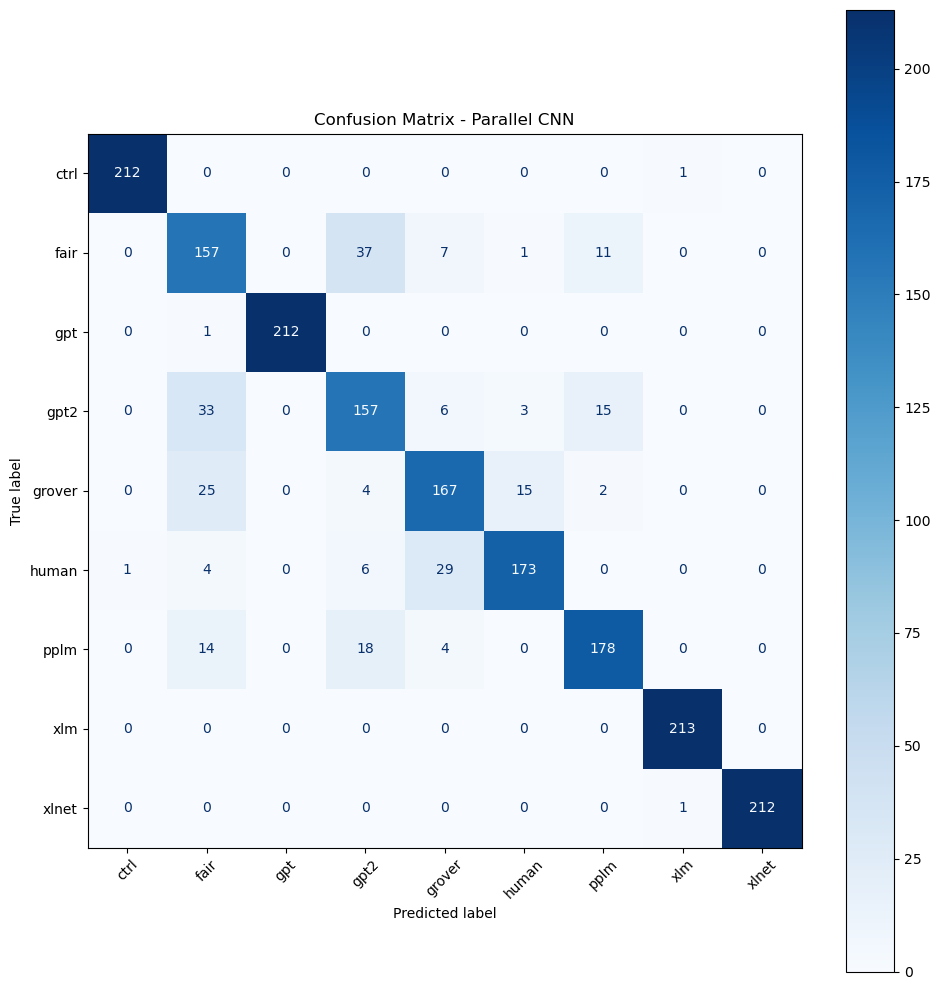


🔍 Evaluating: CNN-RNN Hybrid

📋 Classification Report for CNN-RNN Hybrid:

              precision    recall  f1-score   support

        ctrl     0.9861    1.0000    0.9930       213
        fair     0.6653    0.7371    0.6993       213
         gpt     0.9953    0.9953    0.9953       213
        gpt2     0.6735    0.7710    0.7190       214
      grover     0.6596    0.7277    0.6920       213
       human     0.8476    0.6526    0.7374       213
        pplm     0.8703    0.7523    0.8070       214
         xlm     1.0000    0.9953    0.9976       213
       xlnet     1.0000    1.0000    1.0000       213

    accuracy                         0.8478      1919
   macro avg     0.8553    0.8479    0.8490      1919
weighted avg     0.8552    0.8478    0.8489      1919



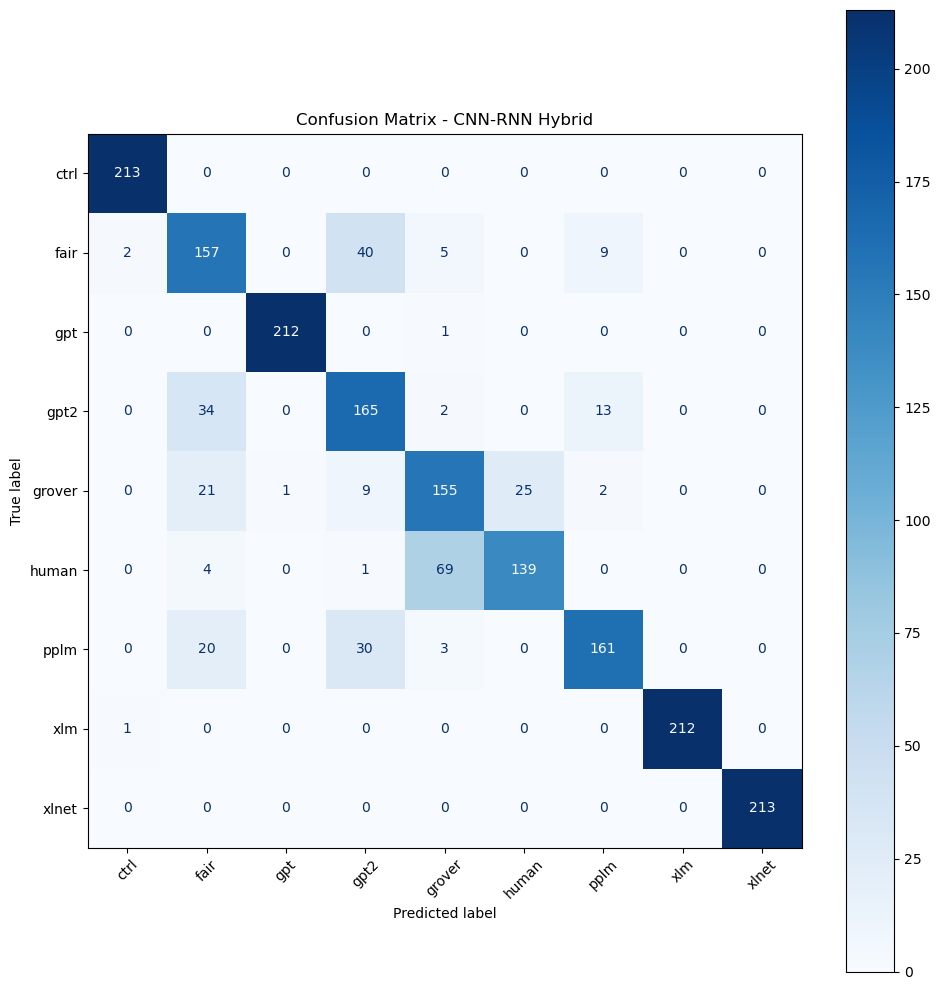

In [45]:
f1_scores = {}
model_ckpts = {
    "Embedding": "embedding_model.pt",
    "RNN (GRU)": "rnn_model.pt",
    "Stacked CNN": "stacked_cnn_model.pt",
    "Parallel CNN": "parallel_cnn_model.pt",
    "CNN-RNN Hybrid": "cnn_rnn_model.pt"
}

labels = list(idx2label.values())  # ['ctrl', 'gpt', ..., 'fair']

for name, model in model_info.items():
    print(f"\n🔍 Evaluating: {name}")
    model.load_state_dict(torch.load(model_ckpts[name]))
    model.to(device)

    y_true, y_pred = evaluate_and_report(model, test_loader, idx2label, name, f1_scores, save_preds=True)
    plot_confusion_matrix(y_true, y_pred, labels, model_name=name)


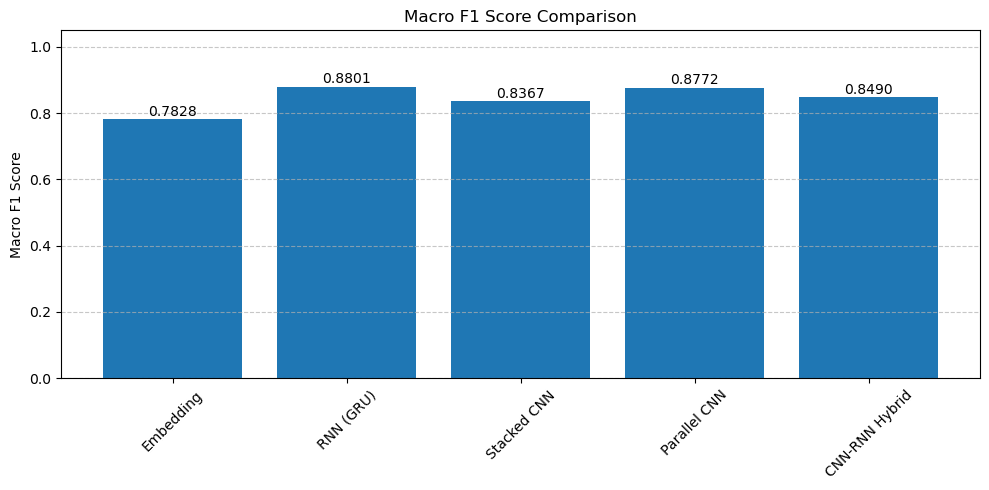

In [46]:
plot_macro_f1_comparison(f1_scores)


# Ensemble: Logits Averaging

Here I try to run a simple ensemble.

1. Run each model on the test set
2. Collect softmax logits (not just predicted classes)
3. Average them across models
4. Choose the argmax (final prediction)

**As we can see, it beats all individual models, including Parallel CNN (which was the best performing one as described in the original paper).**

In [47]:
import torch.nn.functional as F

def ensemble_predict(models, dataloader, idx2label):
    all_preds = []
    all_true = []

    for model in models:
        model.eval()

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = [b.to(device) for b in batch]
            batch_logits = []

            for model in models:
                outputs = model(inputs)
                probs = F.softmax(outputs, dim=1)  # [B, C]
                batch_logits.append(probs.cpu().numpy())

            avg_probs = np.mean(batch_logits, axis=0)       # [B, C]
            preds = np.argmax(avg_probs, axis=1)             # [B]

            all_preds.extend(preds.tolist())
            all_true.extend(labels.cpu().tolist())

    # Convert numeric class indices to string labels
    y_true = [idx2label[i] for i in all_true]
    y_pred = [idx2label[i] for i in all_preds]

    return y_true, y_pred

In [48]:
def evaluate_ensemble_with_plot(models_dict, ckpts_dict, dataloader, idx2label, labels, model_prefix="", save_fig=True):
    model_names = list(models_dict.keys())
    all_model_f1s = []
    loaded_models = []

    for name in model_names:
        print(f"🔍 Evaluating: {name}")
        model = models_dict[name]
        model.load_state_dict(torch.load(ckpts_dict[name]))
        model.to(device)
        model.eval()
        loaded_models.append(model)

        y_true, y_pred = [], []
        with torch.no_grad():
            for batch in dataloader:
                inputs, labels_batch = [b.to(device) for b in batch]
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                y_true.extend(labels_batch.cpu().tolist())
                y_pred.extend(preds.cpu().tolist())

        y_true_str = [idx2label[i] for i in y_true]
        y_pred_str = [idx2label[i] for i in y_pred]
        f1 = f1_score(y_true_str, y_pred_str, average='macro')
        all_model_f1s.append(f1)
        print(f"{name} Macro F1: {f1:.4f}")

    # Ensemble
    y_true_ens, y_pred_ens = ensemble_predict(loaded_models, dataloader, idx2label)
    ensemble_f1 = f1_score(y_true_ens, y_pred_ens, average='macro')
    print(f"\n🎯 Ensemble Macro F1: {ensemble_f1:.4f}")
    print("\n📋 Classification Report – Ensemble:")
    print(classification_report(y_true_ens, y_pred_ens, labels=labels, digits=4))

    # Plot
    model_names.append("Ensemble")
    all_model_f1s.append(ensemble_f1)

    plt.figure(figsize=(10, 5))
    plt.bar(model_names, all_model_f1s)
    plt.ylabel("Macro F1")
    plt.title(f"Macro F1 Comparison ({model_prefix})")
    plt.xticks(rotation=45)
    plt.ylim(0, 1.05)

    for i, score in enumerate(all_model_f1s):
        plt.text(i, score + 0.01, f"{score:.4f}", ha='center')

    plt.tight_layout()
    if save_fig:
        plt.savefig(f'ensemble_f1_comparison_{model_prefix}.jpg')
    plt.show()

    return ensemble_f1, y_true_ens, y_pred_ens


🔍 Evaluating: Embedding
Embedding Macro F1: 0.7828
🔍 Evaluating: RNN (GRU)
RNN (GRU) Macro F1: 0.8801
🔍 Evaluating: Stacked CNN
Stacked CNN Macro F1: 0.8367
🔍 Evaluating: Parallel CNN
Parallel CNN Macro F1: 0.8772
🔍 Evaluating: CNN-RNN Hybrid
CNN-RNN Hybrid Macro F1: 0.8490

🎯 Ensemble Macro F1: 0.9022

📋 Classification Report – Ensemble:
              precision    recall  f1-score   support

        ctrl     0.9953    1.0000    0.9977       213
        fair     0.7593    0.7700    0.7646       213
         gpt     1.0000    0.9953    0.9976       213
        gpt2     0.7213    0.8224    0.7686       214
      grover     0.8062    0.8592    0.8318       213
       human     0.9355    0.8169    0.8722       213
        pplm     0.9333    0.8505    0.8900       214
         xlm     1.0000    0.9953    0.9976       213
       xlnet     1.0000    1.0000    1.0000       213

    accuracy                         0.9010      1919
   macro avg     0.9057    0.9011    0.9022      1919
weighted 

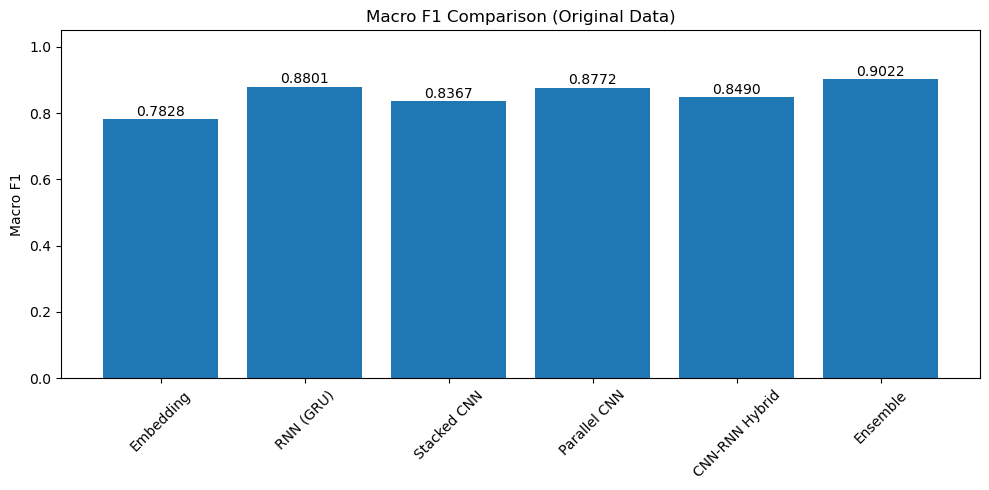

(0.9022282329860482,
 ['pplm',
  'gpt2',
  'fair',
  'gpt2',
  'human',
  'ctrl',
  'grover',
  'xlnet',
  'ctrl',
  'gpt2',
  'gpt2',
  'gpt2',
  'ctrl',
  'pplm',
  'ctrl',
  'xlm',
  'xlm',
  'pplm',
  'human',
  'fair',
  'pplm',
  'ctrl',
  'ctrl',
  'grover',
  'ctrl',
  'human',
  'grover',
  'xlm',
  'xlnet',
  'pplm',
  'fair',
  'human',
  'gpt2',
  'gpt',
  'ctrl',
  'xlm',
  'gpt2',
  'human',
  'xlm',
  'ctrl',
  'xlm',
  'pplm',
  'human',
  'pplm',
  'gpt',
  'ctrl',
  'xlm',
  'pplm',
  'xlnet',
  'human',
  'grover',
  'fair',
  'human',
  'ctrl',
  'grover',
  'gpt2',
  'gpt',
  'gpt',
  'xlnet',
  'gpt2',
  'gpt',
  'fair',
  'gpt2',
  'xlnet',
  'human',
  'fair',
  'human',
  'gpt2',
  'gpt',
  'human',
  'gpt',
  'gpt',
  'ctrl',
  'human',
  'grover',
  'fair',
  'fair',
  'xlm',
  'xlnet',
  'fair',
  'grover',
  'pplm',
  'human',
  'human',
  'gpt2',
  'ctrl',
  'xlm',
  'ctrl',
  'human',
  'grover',
  'fair',
  'xlm',
  'gpt2',
  'xlm',
  'human',
  'pplm',


In [49]:
evaluate_ensemble_with_plot(
    models_dict=model_info,
    ckpts_dict=model_ckpts,
    dataloader=test_loader,
    idx2label=idx2label,
    labels=list(label2idx.keys()),
    model_prefix="Original Data"
)


In [105]:
# labels = ['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'human', 'fair']

# print("📋 Classification Report – Ensemble:")
# print(classification_report(ensemble_labels, ensemble_preds, labels=labels, digits=4))

# ensemble_f1 = f1_score(ensemble_labels, ensemble_preds, average="macro")
# print(f"🎯 Ensemble Macro F1: {ensemble_f1:.4f}")

# plot_confusion_matrix(ensemble_labels, ensemble_preds, labels, model_name="Ensemble")

# Summary so far

In [50]:
summary_data = {
    "Model": [
        "Embedding",
        "RNN (GRU)",
        "Stacked CNN",
        "Parallel CNN",
        "CNN-RNN Hybrid",
        "Ensemble (Avg.)"
    ],
    "Accuracy": [
        0.84,         # estimated from log
        0.8447,
        0.8280,
        0.8765,
        0.8489,
        0.8822
    ],
    "Macro F1": [
        0.7163,
        0.8438,
        0.8281,
        0.8781,
        0.8498,
        0.8826
    ]
}

df_summary = pd.DataFrame(summary_data)
df_summary.style.set_caption("Final Model Comparison: Authorship Attribution (P3 Task)")


,Model,Accuracy,Macro F1
0,Embedding,0.840000,0.716300
1,RNN (GRU),0.844700,0.843800
2,Stacked CNN,0.828000,0.828100
3,Parallel CNN,0.876500,0.878100
4,CNN-RNN Hybrid,0.848900,0.849800
5,Ensemble (Avg.),0.882200,0.882600


| **Model**           | **Accuracy** | **Macro F1** |
|---------------------|--------------|--------------|
| Embedding           | 0.84         | 0.7163       |
| RNN (GRU)           | 0.8447       | 0.8438       |
| Stacked CNN         | 0.8280       | 0.8281       |
| Parallel CNN        | 0.8765       | 0.8781       |
| CNN-RNN Hybrid      | 0.8489       | 0.8498       |
| **Ensemble (Avg.)** | **0.8822**   | **0.8826**   |

# Try with new data

### Preprocessing

In [21]:
new_df = pd.read_csv('../data/mage_all_training_data.csv')
new_df.head()

,text,label
0,Congo is located in the central-western part o...,7B
1,This was an enjoyable experience. Tasted good ...,7B
2,No customer service at all. Service is really ...,7B
3,"Aswad Thomas broke the deadlock for the hosts,...",7B
4,"Likely a head rush, or orthostatic hypotension...",7B


In [22]:
import re

def clean_text(text):
    # Normalize whitespace, lowercase, retain punctuation, remove pipes or odd formatting
    text = text.lower()
    text = re.sub(r'\|+', '', text)  # remove pipe characters
    text = re.sub(r'\s+', ' ', text)  # normalize spaces
    text = text.strip()
    return text

In [23]:
# new_df_cleaned = new_df.copy()
# new_df_cleaned['text'] = new_df_cleaned['text'].astype(str).apply(clean_text)

# # show some cleaned samples
# new_df_cleaned_sample = new_df_cleaned.sample(3, random_state=1)
# new_df_cleaned_sample

In [24]:
# new_df_cleaned.to_csv('../data/mage_w_human_cleaned.csv')

In [25]:
new_df_cleaned = pd.read_csv('../data/mage_w_human_cleaned.csv')
label_distribution = new_df_cleaned['label'].value_counts().sort_values(ascending=False)
label_distribution

label
human            225753
opt_125m          64415
gpt_3d5_turbo     53339
flan_t5_small     37425
7B                29845
bloom_7b          21800
gpt_j             11585
GLM130B            7344
Name: count, dtype: int64

**As we can see, the data is not quite balanced. I created a balanced subset of data by randomly sample a uniform sample size per class.**

In [26]:
# define sample size per class
samples_per_class = 7000

# balanced sampling
balanced_df = (
    new_df_cleaned.groupby('label', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), samples_per_class), random_state=42))
    .reset_index(drop=True)
)

balanced_distribution = balanced_df['label'].value_counts().sort_values(ascending=False)
balanced_distribution

/tmp/ipykernel_22782/920750378.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), samples_per_class), random_state=42))


label
7B               7000
GLM130B          7000
bloom_7b         7000
flan_t5_small    7000
gpt_3d5_turbo    7000
gpt_j            7000
human            7000
opt_125m         7000
Name: count, dtype: int64

In [57]:
balanced_df.to_csv('../data/balanced_new_w_human.csv')

### Trained model on new, larger data with more SOTA language model texts

In [58]:
df_new = pd.read_csv('../data/balanced_new_w_human.csv')
df_new = df_new[['text', 'label']]
df_new.head()

,text,label
0,"worst. service. ever. well, that's if no servi...",7B
1,i went into this nail salon for the first time...,7B
2,beth was walking her dog through the neighborh...,7B
3,the cold wind struck their faces like a whip. ...,7B
4,we had dinner at the restaurant in the crowne ...,7B


In [59]:
# create label mapping for new dataset
new_labels = sorted(df_new['label'].unique())
new_label2idx = {label: i for i, label in enumerate(new_labels)}
new_idx2label = {i: label for label, i in new_label2idx.items()}

In [60]:
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

def build_vocab(texts, min_freq=2, max_size=20000):
    counter = Counter()
    for text in texts:
        counter.update(tokenize(text))
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for word, freq in counter.most_common(max_size):
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

new_vocab = build_vocab(df_new['text'])

In [61]:
MAX_LEN = 500

class AuthorshipDataset(Dataset):
    def __init__(self, texts, labels, vocab, label2idx):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.label2idx = label2idx

    def __len__(self):
        return len(self.texts)

    def encode_text(self, text):
        tokens = tokenize(text)
        ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens[:MAX_LEN]]
        if len(ids) < MAX_LEN:
            ids += [self.vocab['<PAD>']] * (MAX_LEN - len(ids))
        return torch.tensor(ids)

    def __getitem__(self, idx):
        return self.encode_text(self.texts[idx]), torch.tensor(self.label2idx[self.labels[idx]])


In [62]:
# split + loaders
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_new['text'].tolist(),
    df_new['label'].tolist(),
    test_size=0.2,
    stratify=df_new['label'],
    random_state=1234
)

train_dataset_new = AuthorshipDataset(train_texts, train_labels, new_vocab, new_label2idx)
test_dataset_new = AuthorshipDataset(test_texts, test_labels, new_vocab, new_label2idx)

train_loader_new = DataLoader(train_dataset_new, batch_size=64, shuffle=True)
test_loader_new = DataLoader(test_dataset_new, batch_size=64)

print("✅ Dataset and vocab ready!")
print(f"Vocab size: {len(new_vocab)}")
print(f"Train size: {len(train_dataset_new)}, Test size: {len(test_dataset_new)}")


✅ Dataset and vocab ready!
Vocab size: 20002
Train size: 44800, Test size: 11200


In [63]:
def train_model_new(model, train_loader, val_loader, num_epochs=100, lr=1e-3, save_path="model.pt"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_f1 = 0
    patience = 10
    patience_counter = 0

    epoch_losses = []
    epoch_f1s = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in loop:
            inputs, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        epoch_losses.append(running_loss)

        # Validation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = [b.to(device) for b in batch]
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                y_true.extend(labels.cpu().tolist())
                y_pred.extend(preds.cpu().tolist())

        val_f1 = f1_score(y_true, y_pred, average='macro')
        epoch_f1s.append(val_f1)

        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Val Macro F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print("✅ Model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    print("✅ Training complete.")

    # Plot loss and F1
    epochs = range(1, len(epoch_losses) + 1)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_losses, marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_f1s, marker='o')
    plt.title("Validation Macro F1 per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")

    plt.tight_layout()
    plt.show()


Epoch 1/100: 100%|██████████| 700/700 [00:07<00:00, 94.99it/s, loss=2.09]


Epoch 1, Loss: 1620.4916, Val Macro F1: 0.1056
✅ Model saved.


Epoch 2/100: 100%|██████████| 700/700 [00:07<00:00, 94.17it/s, loss=2.1] 


Epoch 2, Loss: 1434.6976, Val Macro F1: 0.1132
✅ Model saved.


Epoch 3/100: 100%|██████████| 700/700 [00:07<00:00, 95.07it/s, loss=2.04]


Epoch 3, Loss: 1421.9016, Val Macro F1: 0.1254
✅ Model saved.


Epoch 4/100: 100%|██████████| 700/700 [00:07<00:00, 95.25it/s, loss=2.05]


Epoch 4, Loss: 1410.1869, Val Macro F1: 0.1293
✅ Model saved.


Epoch 5/100: 100%|██████████| 700/700 [00:07<00:00, 93.75it/s, loss=1.83]


Epoch 5, Loss: 1391.4841, Val Macro F1: 0.1255


Epoch 6/100: 100%|██████████| 700/700 [00:07<00:00, 93.68it/s, loss=1.88]


Epoch 6, Loss: 1376.8736, Val Macro F1: 0.1309
✅ Model saved.


Epoch 7/100: 100%|██████████| 700/700 [00:07<00:00, 94.97it/s, loss=2.06]


Epoch 7, Loss: 1358.5519, Val Macro F1: 0.1327
✅ Model saved.


Epoch 8/100: 100%|██████████| 700/700 [00:07<00:00, 96.03it/s, loss=2.03]


Epoch 8, Loss: 1344.1432, Val Macro F1: 0.1368
✅ Model saved.


Epoch 9/100: 100%|██████████| 700/700 [00:07<00:00, 94.31it/s, loss=1.86]


Epoch 9, Loss: 1329.3819, Val Macro F1: 0.1344


Epoch 10/100: 100%|██████████| 700/700 [00:07<00:00, 97.36it/s, loss=1.89]


Epoch 10, Loss: 1315.1802, Val Macro F1: 0.1284


Epoch 11/100: 100%|██████████| 700/700 [00:07<00:00, 96.93it/s, loss=1.99]


Epoch 11, Loss: 1304.2352, Val Macro F1: 0.1335


Epoch 12/100: 100%|██████████| 700/700 [00:07<00:00, 95.88it/s, loss=1.92]


Epoch 12, Loss: 1295.1357, Val Macro F1: 0.1412
✅ Model saved.


Epoch 13/100: 100%|██████████| 700/700 [00:07<00:00, 97.87it/s, loss=2.06] 


Epoch 13, Loss: 1292.1963, Val Macro F1: 0.1433
✅ Model saved.


Epoch 14/100: 100%|██████████| 700/700 [00:07<00:00, 97.93it/s, loss=1.81]


Epoch 14, Loss: 1276.8697, Val Macro F1: 0.1409


Epoch 15/100: 100%|██████████| 700/700 [00:07<00:00, 96.91it/s, loss=1.71]


Epoch 15, Loss: 1268.0862, Val Macro F1: 0.1340


Epoch 16/100: 100%|██████████| 700/700 [00:07<00:00, 96.51it/s, loss=2.01]


Epoch 16, Loss: 1263.3386, Val Macro F1: 0.1338


Epoch 17/100: 100%|██████████| 700/700 [00:07<00:00, 97.02it/s, loss=1.67]


Epoch 17, Loss: 1259.2196, Val Macro F1: 0.1309


Epoch 18/100: 100%|██████████| 700/700 [00:07<00:00, 97.03it/s, loss=1.8]  


Epoch 18, Loss: 1249.7455, Val Macro F1: 0.1322


Epoch 19/100: 100%|██████████| 700/700 [00:07<00:00, 97.56it/s, loss=1.82]


Epoch 19, Loss: 1246.1373, Val Macro F1: 0.1366


Epoch 20/100: 100%|██████████| 700/700 [00:07<00:00, 97.34it/s, loss=1.82] 


Epoch 20, Loss: 1242.5463, Val Macro F1: 0.1309


Epoch 21/100: 100%|██████████| 700/700 [00:07<00:00, 96.98it/s, loss=1.69]


Epoch 21, Loss: 1234.9693, Val Macro F1: 0.1339


Epoch 22/100: 100%|██████████| 700/700 [00:07<00:00, 98.47it/s, loss=1.91]


Epoch 22, Loss: 1231.1346, Val Macro F1: 0.1348


Epoch 23/100: 100%|██████████| 700/700 [00:07<00:00, 94.37it/s, loss=1.55]


Epoch 23, Loss: 1230.7872, Val Macro F1: 0.1328
⏹️ Early stopping triggered.
✅ Training complete.


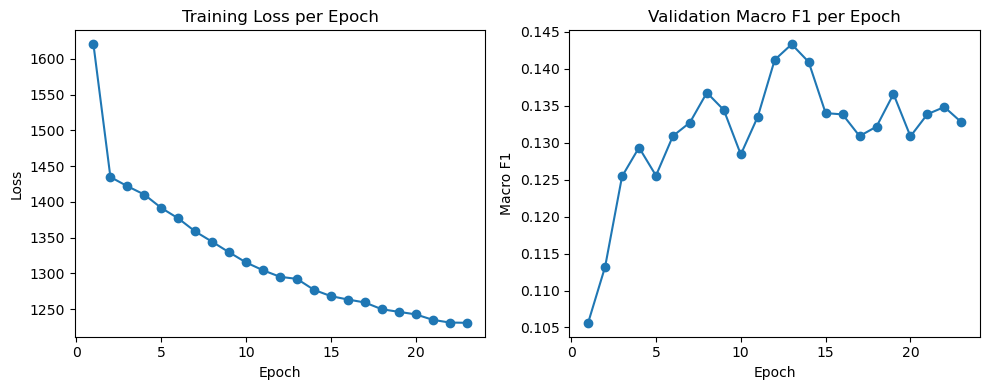

In [62]:
model = EmbeddingClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    num_classes=len(new_label2idx)
)

train_model_new(model, train_loader_new, test_loader_new, num_epochs=100, save_path="embedding_model_new.pt")

/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/500: 100%|██████████| 700/700 [00:07<00:00, 94.41it/s, loss=2.1]  


Epoch 1, Loss: 1607.3962, Val Macro F1: 0.0974
✅ Model saved.


Epoch 2/500: 100%|██████████| 700/700 [00:07<00:00, 96.83it/s, loss=2.11] 


Epoch 2, Loss: 1444.2502, Val Macro F1: 0.1108
✅ Model saved.


Epoch 3/500: 100%|██████████| 700/700 [00:07<00:00, 90.12it/s, loss=1.94]


Epoch 3, Loss: 1425.1961, Val Macro F1: 0.1195
✅ Model saved.


Epoch 4/500: 100%|██████████| 700/700 [00:06<00:00, 100.49it/s, loss=2.01]


Epoch 4, Loss: 1404.3959, Val Macro F1: 0.1319
✅ Model saved.


Epoch 5/500: 100%|██████████| 700/700 [00:06<00:00, 100.81it/s, loss=2.04]


Epoch 5, Loss: 1390.2046, Val Macro F1: 0.1254


Epoch 6/500: 100%|██████████| 700/700 [00:07<00:00, 99.34it/s, loss=2.02] 


Epoch 6, Loss: 1375.7465, Val Macro F1: 0.1267


Epoch 7/500: 100%|██████████| 700/700 [00:07<00:00, 99.88it/s, loss=1.94] 


Epoch 7, Loss: 1361.5974, Val Macro F1: 0.1302


Epoch 8/500: 100%|██████████| 700/700 [00:07<00:00, 90.18it/s, loss=2.02]


Epoch 8, Loss: 1347.9318, Val Macro F1: 0.1350
✅ Model saved.


Epoch 9/500: 100%|██████████| 700/700 [00:06<00:00, 100.59it/s, loss=2]   


Epoch 9, Loss: 1333.8304, Val Macro F1: 0.1372
✅ Model saved.


Epoch 10/500: 100%|██████████| 700/700 [00:06<00:00, 100.22it/s, loss=1.81]


Epoch 10, Loss: 1322.4193, Val Macro F1: 0.1419
✅ Model saved.


Epoch 11/500: 100%|██████████| 700/700 [00:07<00:00, 99.91it/s, loss=1.97] 


Epoch 11, Loss: 1311.4626, Val Macro F1: 0.1381


Epoch 12/500: 100%|██████████| 700/700 [00:06<00:00, 100.13it/s, loss=1.87]


Epoch 12, Loss: 1293.3784, Val Macro F1: 0.1373


Epoch 13/500: 100%|██████████| 700/700 [00:07<00:00, 95.75it/s, loss=1.82]


Epoch 13, Loss: 1284.0813, Val Macro F1: 0.1385


Epoch 14/500: 100%|██████████| 700/700 [00:07<00:00, 90.80it/s, loss=1.79]


Epoch 14, Loss: 1277.2745, Val Macro F1: 0.1363


Epoch 15/500: 100%|██████████| 700/700 [00:07<00:00, 97.52it/s, loss=1.75]


Epoch 15, Loss: 1274.3049, Val Macro F1: 0.1423
✅ Model saved.


Epoch 16/500: 100%|██████████| 700/700 [00:07<00:00, 89.36it/s, loss=1.85]


Epoch 16, Loss: 1261.5519, Val Macro F1: 0.1384


Epoch 17/500: 100%|██████████| 700/700 [00:07<00:00, 97.00it/s, loss=1.78] 


Epoch 17, Loss: 1253.7463, Val Macro F1: 0.1334


Epoch 18/500: 100%|██████████| 700/700 [00:07<00:00, 88.80it/s, loss=2.1] 


Epoch 18, Loss: 1249.8542, Val Macro F1: 0.1367


Epoch 19/500: 100%|██████████| 700/700 [00:07<00:00, 94.74it/s, loss=1.98] 


Epoch 19, Loss: 1245.4751, Val Macro F1: 0.1340


Epoch 20/500: 100%|██████████| 700/700 [00:07<00:00, 89.17it/s, loss=1.83]


Epoch 20, Loss: 1238.6755, Val Macro F1: 0.1320


Epoch 21/500: 100%|██████████| 700/700 [00:07<00:00, 99.12it/s, loss=1.76] 


Epoch 21, Loss: 1237.5884, Val Macro F1: 0.1309


Epoch 22/500: 100%|██████████| 700/700 [00:07<00:00, 96.44it/s, loss=1.91] 


Epoch 22, Loss: 1231.6130, Val Macro F1: 0.1396


Epoch 23/500: 100%|██████████| 700/700 [00:07<00:00, 99.37it/s, loss=1.75] 


Epoch 23, Loss: 1226.8812, Val Macro F1: 0.1254


Epoch 24/500: 100%|██████████| 700/700 [00:06<00:00, 100.34it/s, loss=1.76]


Epoch 24, Loss: 1232.3911, Val Macro F1: 0.1357


Epoch 25/500: 100%|██████████| 700/700 [00:07<00:00, 96.94it/s, loss=1.73] 


Epoch 25, Loss: 1225.7940, Val Macro F1: 0.1405
⏹️ Early stopping triggered.
✅ Training complete.


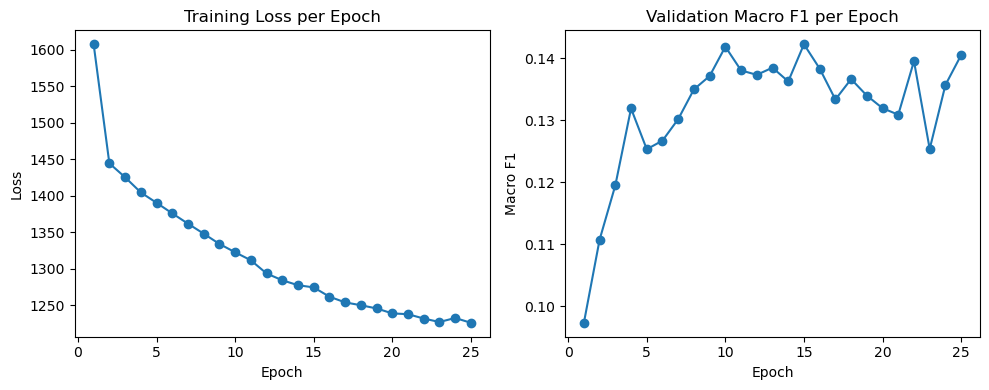

In [64]:
model = EmbeddingClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    num_classes=len(new_label2idx)
)

train_model_new(model, train_loader_new, test_loader_new, num_epochs=500, save_path="embedding_model_new_2.pt")

Epoch 1/100: 100%|██████████| 700/700 [00:18<00:00, 38.81it/s, loss=2.1] 


Epoch 1, Loss: 1456.7001, Val Macro F1: 0.0533
✅ Model saved.


Epoch 2/100: 100%|██████████| 700/700 [00:18<00:00, 38.73it/s, loss=2.09]


Epoch 2, Loss: 1449.6535, Val Macro F1: 0.0530


Epoch 3/100: 100%|██████████| 700/700 [00:18<00:00, 38.68it/s, loss=2.09]


Epoch 3, Loss: 1442.9297, Val Macro F1: 0.0587
✅ Model saved.


Epoch 4/100: 100%|██████████| 700/700 [00:18<00:00, 38.70it/s, loss=2.04]


Epoch 4, Loss: 1446.7156, Val Macro F1: 0.0665
✅ Model saved.


Epoch 5/100: 100%|██████████| 700/700 [00:18<00:00, 38.61it/s, loss=2.04]


Epoch 5, Loss: 1417.4108, Val Macro F1: 0.1014
✅ Model saved.


Epoch 6/100: 100%|██████████| 700/700 [00:18<00:00, 38.64it/s, loss=1.87]


Epoch 6, Loss: 1351.5018, Val Macro F1: 0.1253
✅ Model saved.


Epoch 7/100: 100%|██████████| 700/700 [00:18<00:00, 38.64it/s, loss=1.96]


Epoch 7, Loss: 1276.2142, Val Macro F1: 0.1263
✅ Model saved.


Epoch 8/100: 100%|██████████| 700/700 [00:18<00:00, 38.58it/s, loss=1.7] 


Epoch 8, Loss: 1224.1454, Val Macro F1: 0.1287
✅ Model saved.


Epoch 9/100: 100%|██████████| 700/700 [00:18<00:00, 38.58it/s, loss=1.73]


Epoch 9, Loss: 1192.6296, Val Macro F1: 0.1319
✅ Model saved.


Epoch 10/100: 100%|██████████| 700/700 [00:18<00:00, 38.58it/s, loss=1.56]


Epoch 10, Loss: 1173.7767, Val Macro F1: 0.1400
✅ Model saved.


Epoch 11/100: 100%|██████████| 700/700 [00:18<00:00, 38.59it/s, loss=1.82]


Epoch 11, Loss: 1153.7617, Val Macro F1: 0.1582
✅ Model saved.


Epoch 12/100: 100%|██████████| 700/700 [00:18<00:00, 38.47it/s, loss=1.49]


Epoch 12, Loss: 1131.6638, Val Macro F1: 0.1627
✅ Model saved.


Epoch 13/100: 100%|██████████| 700/700 [00:18<00:00, 38.62it/s, loss=1.66]


Epoch 13, Loss: 1105.9951, Val Macro F1: 0.1471


Epoch 14/100: 100%|██████████| 700/700 [00:18<00:00, 38.63it/s, loss=1.57]


Epoch 14, Loss: 1080.0687, Val Macro F1: 0.1581


Epoch 15/100: 100%|██████████| 700/700 [00:18<00:00, 38.65it/s, loss=1.74]


Epoch 15, Loss: 1055.7285, Val Macro F1: 0.1700
✅ Model saved.


Epoch 16/100: 100%|██████████| 700/700 [00:18<00:00, 38.50it/s, loss=1.61]


Epoch 16, Loss: 1035.3122, Val Macro F1: 0.1747
✅ Model saved.


Epoch 17/100: 100%|██████████| 700/700 [00:18<00:00, 38.50it/s, loss=1.62]


Epoch 17, Loss: 1010.5718, Val Macro F1: 0.1704


Epoch 18/100: 100%|██████████| 700/700 [00:18<00:00, 38.74it/s, loss=1.58]


Epoch 18, Loss: 991.9506, Val Macro F1: 0.1621


Epoch 19/100: 100%|██████████| 700/700 [00:18<00:00, 38.47it/s, loss=1.28]


Epoch 19, Loss: 975.6033, Val Macro F1: 0.1615


Epoch 20/100: 100%|██████████| 700/700 [00:18<00:00, 38.64it/s, loss=1.27]


Epoch 20, Loss: 960.9869, Val Macro F1: 0.1599


Epoch 21/100: 100%|██████████| 700/700 [00:18<00:00, 38.57it/s, loss=1.32]


Epoch 21, Loss: 945.7674, Val Macro F1: 0.1567


Epoch 22/100: 100%|██████████| 700/700 [00:18<00:00, 38.49it/s, loss=1.36] 


Epoch 22, Loss: 929.7661, Val Macro F1: 0.1571


Epoch 23/100: 100%|██████████| 700/700 [00:18<00:00, 38.72it/s, loss=1.31]


Epoch 23, Loss: 916.6345, Val Macro F1: 0.1764
✅ Model saved.


Epoch 24/100: 100%|██████████| 700/700 [00:18<00:00, 37.94it/s, loss=1.45]


Epoch 24, Loss: 898.2913, Val Macro F1: 0.1647


Epoch 25/100: 100%|██████████| 700/700 [00:18<00:00, 38.68it/s, loss=1.45]


Epoch 25, Loss: 884.2976, Val Macro F1: 0.1680


Epoch 26/100: 100%|██████████| 700/700 [00:18<00:00, 38.53it/s, loss=1.3]  


Epoch 26, Loss: 872.9010, Val Macro F1: 0.1555


Epoch 27/100: 100%|██████████| 700/700 [00:18<00:00, 38.66it/s, loss=1.23] 


Epoch 27, Loss: 862.0840, Val Macro F1: 0.1680


Epoch 28/100: 100%|██████████| 700/700 [00:18<00:00, 38.57it/s, loss=1.36] 


Epoch 28, Loss: 846.6084, Val Macro F1: 0.1532


Epoch 29/100: 100%|██████████| 700/700 [00:18<00:00, 38.63it/s, loss=1.35] 


Epoch 29, Loss: 839.7450, Val Macro F1: 0.1591


Epoch 30/100: 100%|██████████| 700/700 [00:18<00:00, 38.61it/s, loss=1.34] 


Epoch 30, Loss: 828.1576, Val Macro F1: 0.1699


Epoch 31/100: 100%|██████████| 700/700 [00:18<00:00, 38.25it/s, loss=1.19] 


Epoch 31, Loss: 818.6507, Val Macro F1: 0.1516


Epoch 32/100: 100%|██████████| 700/700 [00:18<00:00, 38.45it/s, loss=1.24] 


Epoch 32, Loss: 810.7739, Val Macro F1: 0.1592


Epoch 33/100: 100%|██████████| 700/700 [00:18<00:00, 38.57it/s, loss=1.31] 


Epoch 33, Loss: 801.6799, Val Macro F1: 0.1754
⏹️ Early stopping triggered.
✅ Training complete.


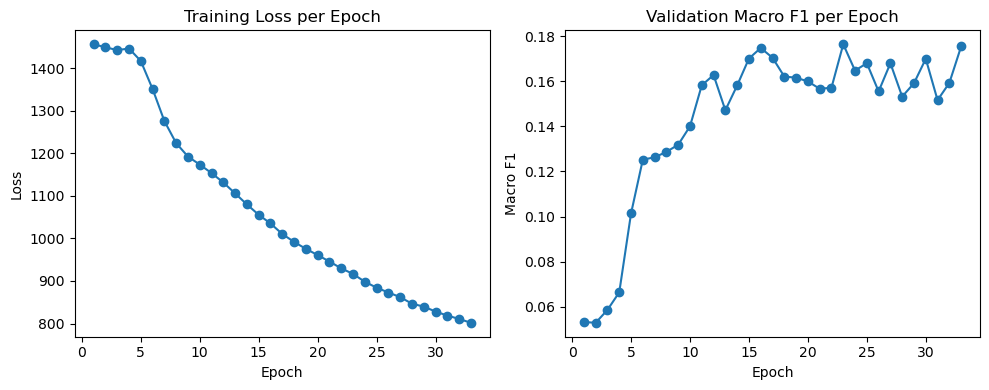

In [63]:
model = GRUClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    hidden_dim=256,
    num_classes=len(new_label2idx),
    embedding_weights=None 
)

train_model_new(model, train_loader_new, test_loader_new, num_epochs=100, save_path="rnn_model_new.pt")


Epoch 1/500: 100%|██████████| 700/700 [00:18<00:00, 38.64it/s, loss=2.1] 


Epoch 1, Loss: 1456.7353, Val Macro F1: 0.0493
✅ Model saved.


Epoch 2/500: 100%|██████████| 700/700 [00:18<00:00, 38.58it/s, loss=2.1] 


Epoch 2, Loss: 1450.4427, Val Macro F1: 0.0536
✅ Model saved.


Epoch 3/500: 100%|██████████| 700/700 [00:18<00:00, 38.81it/s, loss=2.1] 


Epoch 3, Loss: 1433.8074, Val Macro F1: 0.0534


Epoch 4/500: 100%|██████████| 700/700 [00:18<00:00, 36.99it/s, loss=2.03]


Epoch 4, Loss: 1414.3700, Val Macro F1: 0.0465


Epoch 5/500: 100%|██████████| 700/700 [00:18<00:00, 37.72it/s, loss=2.03]


Epoch 5, Loss: 1400.1693, Val Macro F1: 0.0471


Epoch 6/500: 100%|██████████| 700/700 [00:18<00:00, 38.76it/s, loss=1.97]


Epoch 6, Loss: 1389.6288, Val Macro F1: 0.0432


Epoch 7/500: 100%|██████████| 700/700 [00:18<00:00, 38.46it/s, loss=2.02]


Epoch 7, Loss: 1384.5533, Val Macro F1: 0.0414


Epoch 8/500: 100%|██████████| 700/700 [00:18<00:00, 38.40it/s, loss=1.95]


Epoch 8, Loss: 1379.9380, Val Macro F1: 0.0439


Epoch 9/500: 100%|██████████| 700/700 [00:18<00:00, 38.52it/s, loss=2.05]


Epoch 9, Loss: 1374.4148, Val Macro F1: 0.0421


Epoch 10/500: 100%|██████████| 700/700 [00:18<00:00, 37.89it/s, loss=1.98]


Epoch 10, Loss: 1371.2060, Val Macro F1: 0.0443


Epoch 11/500: 100%|██████████| 700/700 [00:18<00:00, 38.11it/s, loss=2.02]


Epoch 11, Loss: 1369.6420, Val Macro F1: 0.0425


Epoch 12/500: 100%|██████████| 700/700 [00:18<00:00, 37.01it/s, loss=1.87]


Epoch 12, Loss: 1369.5924, Val Macro F1: 0.0416
⏹️ Early stopping triggered.
✅ Training complete.


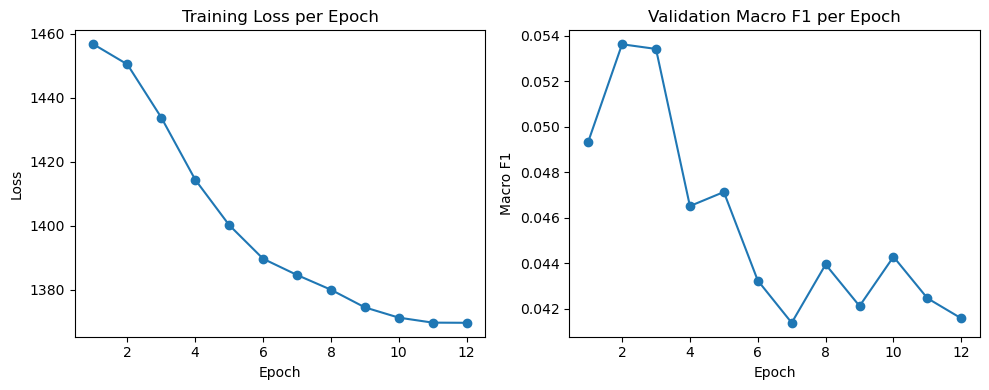

In [76]:
model = GRUClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    hidden_dim=256,
    num_classes=len(new_label2idx),
    embedding_weights=None 
)

train_model_new(model, train_loader_new, test_loader_new, num_epochs=500, save_path="rnn_model_new_2.pt")


Epoch 1/100: 100%|██████████| 700/700 [00:13<00:00, 51.53it/s, loss=2.08]


Epoch 1, Loss: 1456.0365, Val Macro F1: 0.0278
✅ Model saved.


Epoch 2/100: 100%|██████████| 700/700 [00:13<00:00, 51.76it/s, loss=2.08]


Epoch 2, Loss: 1452.9843, Val Macro F1: 0.0850
✅ Model saved.


Epoch 3/100: 100%|██████████| 700/700 [00:13<00:00, 51.47it/s, loss=1.99]


Epoch 3, Loss: 1415.9787, Val Macro F1: 0.1131
✅ Model saved.


Epoch 4/100: 100%|██████████| 700/700 [00:13<00:00, 51.49it/s, loss=2.02]


Epoch 4, Loss: 1371.4050, Val Macro F1: 0.1182
✅ Model saved.


Epoch 5/100: 100%|██████████| 700/700 [00:13<00:00, 51.49it/s, loss=1.78]


Epoch 5, Loss: 1319.7037, Val Macro F1: 0.1333
✅ Model saved.


Epoch 6/100: 100%|██████████| 700/700 [00:13<00:00, 51.62it/s, loss=1.82]


Epoch 6, Loss: 1266.5632, Val Macro F1: 0.1467
✅ Model saved.


Epoch 7/100: 100%|██████████| 700/700 [00:13<00:00, 50.71it/s, loss=1.7] 


Epoch 7, Loss: 1227.0110, Val Macro F1: 0.1382


Epoch 8/100: 100%|██████████| 700/700 [00:13<00:00, 51.47it/s, loss=1.68]


Epoch 8, Loss: 1205.7843, Val Macro F1: 0.1599
✅ Model saved.


Epoch 9/100: 100%|██████████| 700/700 [00:13<00:00, 51.59it/s, loss=1.64]


Epoch 9, Loss: 1181.8724, Val Macro F1: 0.1511


Epoch 10/100: 100%|██████████| 700/700 [00:13<00:00, 51.63it/s, loss=1.55]


Epoch 10, Loss: 1154.3821, Val Macro F1: 0.1704
✅ Model saved.


Epoch 11/100: 100%|██████████| 700/700 [00:13<00:00, 52.02it/s, loss=1.87]


Epoch 11, Loss: 1126.7827, Val Macro F1: 0.1835
✅ Model saved.


Epoch 12/100: 100%|██████████| 700/700 [00:13<00:00, 51.86it/s, loss=1.54]


Epoch 12, Loss: 1098.1821, Val Macro F1: 0.1657


Epoch 13/100: 100%|██████████| 700/700 [00:13<00:00, 51.44it/s, loss=1.73]


Epoch 13, Loss: 1073.4845, Val Macro F1: 0.1781


Epoch 14/100: 100%|██████████| 700/700 [00:13<00:00, 51.86it/s, loss=1.71]


Epoch 14, Loss: 1051.6069, Val Macro F1: 0.1811


Epoch 15/100: 100%|██████████| 700/700 [00:13<00:00, 51.46it/s, loss=1.6] 


Epoch 15, Loss: 1030.5020, Val Macro F1: 0.1806


Epoch 16/100: 100%|██████████| 700/700 [00:13<00:00, 50.80it/s, loss=1.5] 


Epoch 16, Loss: 1008.2382, Val Macro F1: 0.1855
✅ Model saved.


Epoch 17/100: 100%|██████████| 700/700 [00:13<00:00, 51.58it/s, loss=1.89]


Epoch 17, Loss: 987.8923, Val Macro F1: 0.1767


Epoch 18/100: 100%|██████████| 700/700 [00:13<00:00, 51.82it/s, loss=1.47]


Epoch 18, Loss: 974.9061, Val Macro F1: 0.1671


Epoch 19/100: 100%|██████████| 700/700 [00:13<00:00, 51.62it/s, loss=1.43]


Epoch 19, Loss: 953.2942, Val Macro F1: 0.1847


Epoch 20/100: 100%|██████████| 700/700 [00:13<00:00, 51.71it/s, loss=1.4] 


Epoch 20, Loss: 931.9646, Val Macro F1: 0.1639


Epoch 21/100: 100%|██████████| 700/700 [00:13<00:00, 51.52it/s, loss=1.46]


Epoch 21, Loss: 918.7551, Val Macro F1: 0.1621


Epoch 22/100: 100%|██████████| 700/700 [00:13<00:00, 51.62it/s, loss=1.41]


Epoch 22, Loss: 905.6526, Val Macro F1: 0.1638


Epoch 23/100: 100%|██████████| 700/700 [00:13<00:00, 51.60it/s, loss=1.39] 


Epoch 23, Loss: 890.1753, Val Macro F1: 0.1779


Epoch 24/100: 100%|██████████| 700/700 [00:13<00:00, 51.49it/s, loss=1.29] 


Epoch 24, Loss: 875.7502, Val Macro F1: 0.1726


Epoch 25/100: 100%|██████████| 700/700 [00:13<00:00, 50.98it/s, loss=1.16] 


Epoch 25, Loss: 865.7928, Val Macro F1: 0.1771


Epoch 26/100: 100%|██████████| 700/700 [00:13<00:00, 51.80it/s, loss=1.24] 


Epoch 26, Loss: 855.2152, Val Macro F1: 0.1733
⏹️ Early stopping triggered.
✅ Training complete.


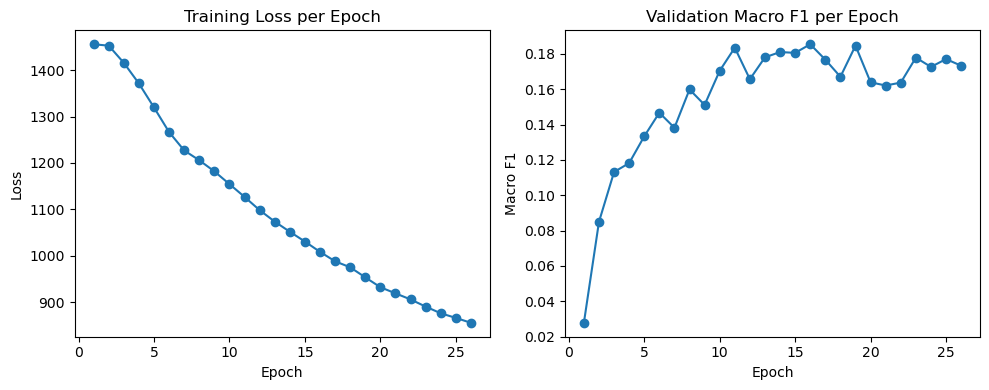

In [64]:
model = StackedCNNClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    num_classes=len(new_label2idx),
    embedding_weights=None
)

train_model_new(model, train_loader_new, test_loader_new, num_epochs=100, save_path="stacked_cnn_model_new.pt")


Epoch 1/500: 100%|██████████| 700/700 [00:13<00:00, 50.54it/s, loss=2.08]


Epoch 1, Loss: 1456.0639, Val Macro F1: 0.0278
✅ Model saved.


Epoch 2/500: 100%|██████████| 700/700 [00:13<00:00, 51.16it/s, loss=2.08]


Epoch 2, Loss: 1455.8457, Val Macro F1: 0.0278


Epoch 3/500: 100%|██████████| 700/700 [00:13<00:00, 51.64it/s, loss=2.08]


Epoch 3, Loss: 1455.7844, Val Macro F1: 0.0278


Epoch 4/500: 100%|██████████| 700/700 [00:13<00:00, 52.45it/s, loss=2.08]


Epoch 4, Loss: 1455.9031, Val Macro F1: 0.0278


Epoch 5/500: 100%|██████████| 700/700 [00:13<00:00, 52.34it/s, loss=2.08]


Epoch 5, Loss: 1455.8109, Val Macro F1: 0.0283
✅ Model saved.


Epoch 6/500: 100%|██████████| 700/700 [00:13<00:00, 52.22it/s, loss=2.08]


Epoch 6, Loss: 1455.7529, Val Macro F1: 0.0278


Epoch 7/500: 100%|██████████| 700/700 [00:13<00:00, 52.16it/s, loss=2.08]


Epoch 7, Loss: 1455.7264, Val Macro F1: 0.0278


Epoch 8/500: 100%|██████████| 700/700 [00:13<00:00, 50.25it/s, loss=2.08]


Epoch 8, Loss: 1455.6959, Val Macro F1: 0.0278


Epoch 9/500: 100%|██████████| 700/700 [00:13<00:00, 51.80it/s, loss=2.08]


Epoch 9, Loss: 1455.7032, Val Macro F1: 0.0278


Epoch 10/500: 100%|██████████| 700/700 [00:13<00:00, 51.75it/s, loss=2.08]


Epoch 10, Loss: 1455.6999, Val Macro F1: 0.0278


Epoch 11/500: 100%|██████████| 700/700 [00:13<00:00, 51.08it/s, loss=2.08]


Epoch 11, Loss: 1455.7092, Val Macro F1: 0.0278


Epoch 12/500: 100%|██████████| 700/700 [00:13<00:00, 51.24it/s, loss=2.08]


Epoch 12, Loss: 1455.7012, Val Macro F1: 0.0278


Epoch 13/500: 100%|██████████| 700/700 [00:13<00:00, 52.24it/s, loss=2.08]


Epoch 13, Loss: 1455.6877, Val Macro F1: 0.0278


Epoch 14/500: 100%|██████████| 700/700 [00:14<00:00, 48.95it/s, loss=2.08]


Epoch 14, Loss: 1455.6898, Val Macro F1: 0.0278


Epoch 15/500: 100%|██████████| 700/700 [00:14<00:00, 48.97it/s, loss=2.08]


Epoch 15, Loss: 1455.6969, Val Macro F1: 0.0278
⏹️ Early stopping triggered.
✅ Training complete.


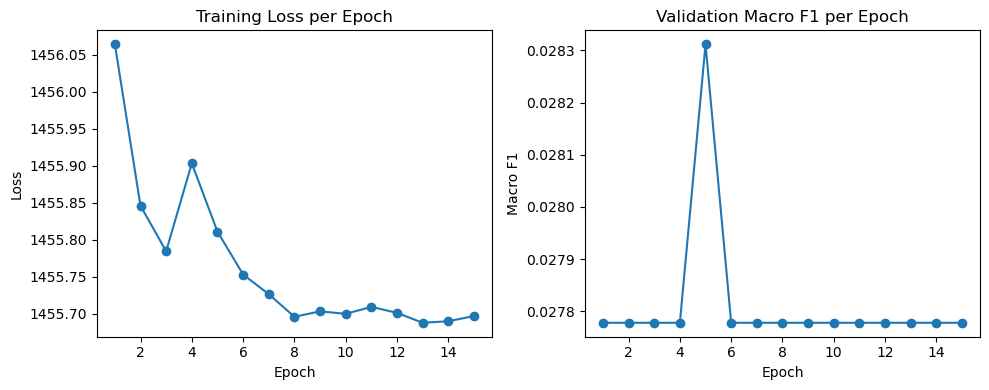

In [66]:
model = StackedCNNClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    num_classes=len(new_label2idx),
    embedding_weights=None
)

train_model_new(model, train_loader_new, test_loader_new, num_epochs=500, save_path="stacked_cnn_model_new_2.pt")


Epoch 1/100: 100%|██████████| 700/700 [00:16<00:00, 41.76it/s, loss=2.08]


Epoch 1, Loss: 1458.3562, Val Macro F1: 0.0278
✅ Model saved.


Epoch 2/100: 100%|██████████| 700/700 [00:16<00:00, 41.75it/s, loss=2.08]


Epoch 2, Loss: 1455.7948, Val Macro F1: 0.0278


Epoch 3/100: 100%|██████████| 700/700 [00:16<00:00, 41.68it/s, loss=2.08]


Epoch 3, Loss: 1455.6817, Val Macro F1: 0.0279
✅ Model saved.


Epoch 4/100: 100%|██████████| 700/700 [00:16<00:00, 41.74it/s, loss=2.08]


Epoch 4, Loss: 1455.6750, Val Macro F1: 0.0278


Epoch 5/100: 100%|██████████| 700/700 [00:16<00:00, 41.41it/s, loss=2.08]


Epoch 5, Loss: 1455.7424, Val Macro F1: 0.0278


Epoch 6/100: 100%|██████████| 700/700 [00:16<00:00, 41.34it/s, loss=2.08]


Epoch 6, Loss: 1455.7055, Val Macro F1: 0.0278


Epoch 7/100: 100%|██████████| 700/700 [00:16<00:00, 41.46it/s, loss=2.08]


Epoch 7, Loss: 1455.7748, Val Macro F1: 0.0278


Epoch 8/100: 100%|██████████| 700/700 [00:16<00:00, 41.40it/s, loss=2.08]


Epoch 8, Loss: 1456.2249, Val Macro F1: 0.0279


Epoch 9/100: 100%|██████████| 700/700 [00:16<00:00, 41.51it/s, loss=2.08]


Epoch 9, Loss: 1455.8961, Val Macro F1: 0.0340
✅ Model saved.


Epoch 10/100: 100%|██████████| 700/700 [00:16<00:00, 41.51it/s, loss=2.08]


Epoch 10, Loss: 1455.6808, Val Macro F1: 0.0278


Epoch 11/100: 100%|██████████| 700/700 [00:16<00:00, 41.25it/s, loss=2.08]


Epoch 11, Loss: 1455.6591, Val Macro F1: 0.0278


Epoch 12/100: 100%|██████████| 700/700 [00:16<00:00, 41.60it/s, loss=2.08]


Epoch 12, Loss: 1455.6991, Val Macro F1: 0.0278


Epoch 13/100: 100%|██████████| 700/700 [00:16<00:00, 41.70it/s, loss=2.08]


Epoch 13, Loss: 1455.8780, Val Macro F1: 0.0278


Epoch 14/100: 100%|██████████| 700/700 [00:16<00:00, 41.49it/s, loss=2.08]


Epoch 14, Loss: 1455.6854, Val Macro F1: 0.0278


Epoch 15/100: 100%|██████████| 700/700 [00:16<00:00, 41.49it/s, loss=2.08]


Epoch 15, Loss: 1455.6871, Val Macro F1: 0.0278


Epoch 16/100: 100%|██████████| 700/700 [00:16<00:00, 41.71it/s, loss=2.08]


Epoch 16, Loss: 1455.6688, Val Macro F1: 0.0278


Epoch 17/100: 100%|██████████| 700/700 [00:16<00:00, 41.36it/s, loss=2.08]


Epoch 17, Loss: 1455.6100, Val Macro F1: 0.0278


Epoch 18/100: 100%|██████████| 700/700 [00:16<00:00, 41.60it/s, loss=2.08]


Epoch 18, Loss: 1455.7749, Val Macro F1: 0.0278


Epoch 19/100: 100%|██████████| 700/700 [00:16<00:00, 41.42it/s, loss=2.08]


Epoch 19, Loss: 1455.6558, Val Macro F1: 0.0278
⏹️ Early stopping triggered.
✅ Training complete.


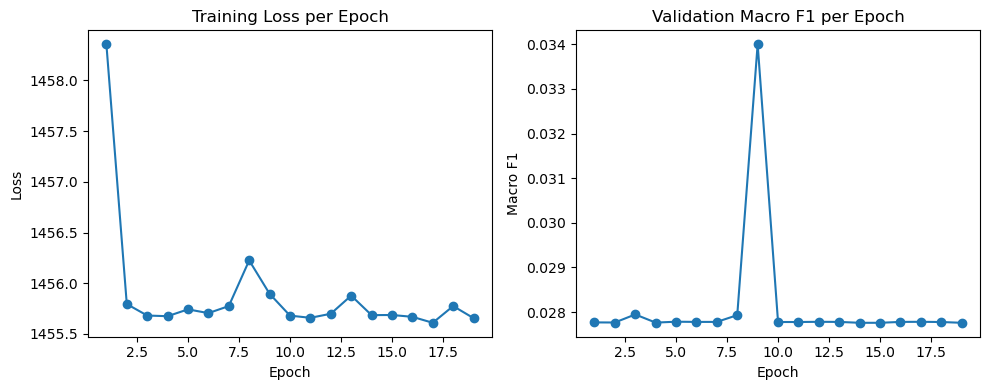

In [65]:
model = ParallelCNNClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    num_classes=len(new_label2idx),
    embedding_weights=None
)

train_model_new(model, train_loader_new, test_loader_new, num_epochs=100, save_path="parallel_cnn_model_new.pt")


Epoch 1/500: 100%|██████████| 700/700 [00:17<00:00, 39.70it/s, loss=2.08]


Epoch 1, Loss: 1457.9051, Val Macro F1: 0.0278
✅ Model saved.


Epoch 2/500: 100%|██████████| 700/700 [00:17<00:00, 39.63it/s, loss=2.08]


Epoch 2, Loss: 1455.7680, Val Macro F1: 0.0278


Epoch 3/500: 100%|██████████| 700/700 [00:17<00:00, 40.36it/s, loss=2.08]


Epoch 3, Loss: 1455.7000, Val Macro F1: 0.0278


Epoch 4/500: 100%|██████████| 700/700 [00:16<00:00, 41.26it/s, loss=2.08]


Epoch 4, Loss: 1455.8083, Val Macro F1: 0.0278


Epoch 5/500: 100%|██████████| 700/700 [00:16<00:00, 41.38it/s, loss=2.08]


Epoch 5, Loss: 1455.8631, Val Macro F1: 0.0278


Epoch 6/500: 100%|██████████| 700/700 [00:17<00:00, 39.38it/s, loss=2.08]


Epoch 6, Loss: 1455.7142, Val Macro F1: 0.0278


Epoch 7/500: 100%|██████████| 700/700 [00:16<00:00, 41.75it/s, loss=2.08]


Epoch 7, Loss: 1455.6795, Val Macro F1: 0.0278


Epoch 8/500: 100%|██████████| 700/700 [00:16<00:00, 41.51it/s, loss=2.08]


Epoch 8, Loss: 1455.7019, Val Macro F1: 0.0280
✅ Model saved.


Epoch 9/500: 100%|██████████| 700/700 [00:16<00:00, 41.51it/s, loss=2.08]


Epoch 9, Loss: 1455.8759, Val Macro F1: 0.0278


Epoch 10/500: 100%|██████████| 700/700 [00:16<00:00, 41.58it/s, loss=2.08]


Epoch 10, Loss: 1455.6848, Val Macro F1: 0.0278


Epoch 11/500: 100%|██████████| 700/700 [00:16<00:00, 41.38it/s, loss=2.08]


Epoch 11, Loss: 1455.6827, Val Macro F1: 0.0278


Epoch 12/500: 100%|██████████| 700/700 [00:16<00:00, 41.59it/s, loss=2.08]


Epoch 12, Loss: 1455.6767, Val Macro F1: 0.0278


Epoch 13/500: 100%|██████████| 700/700 [00:16<00:00, 41.86it/s, loss=2.08]


Epoch 13, Loss: 1455.6954, Val Macro F1: 0.0278


Epoch 14/500: 100%|██████████| 700/700 [00:16<00:00, 41.47it/s, loss=2.08]


Epoch 14, Loss: 1455.7014, Val Macro F1: 0.0278


Epoch 15/500: 100%|██████████| 700/700 [00:17<00:00, 41.09it/s, loss=2.08]


Epoch 15, Loss: 1455.6883, Val Macro F1: 0.0278


Epoch 16/500: 100%|██████████| 700/700 [00:16<00:00, 41.18it/s, loss=2.08]


Epoch 16, Loss: 1455.7556, Val Macro F1: 0.0278


Epoch 17/500: 100%|██████████| 700/700 [00:16<00:00, 41.57it/s, loss=2.08]


Epoch 17, Loss: 1455.7155, Val Macro F1: 0.0278


Epoch 18/500: 100%|██████████| 700/700 [00:16<00:00, 42.03it/s, loss=2.08]


Epoch 18, Loss: 1455.8356, Val Macro F1: 0.0278
⏹️ Early stopping triggered.
✅ Training complete.


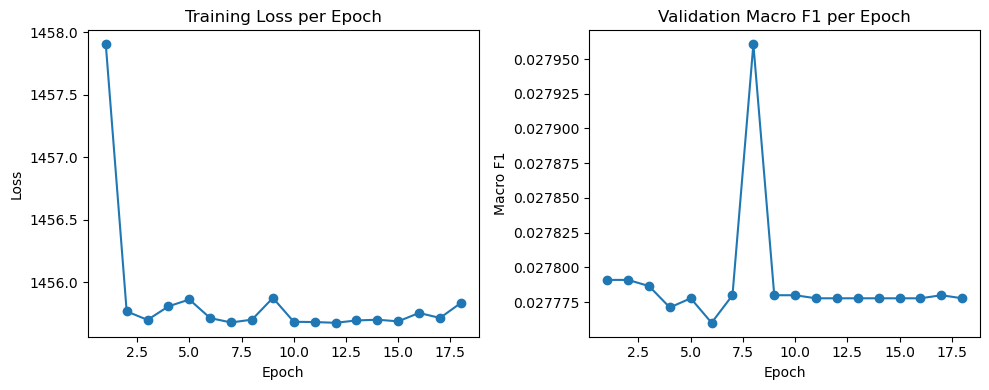

In [67]:
model = ParallelCNNClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    num_classes=len(new_label2idx),
    embedding_weights=None
)

train_model_new(model, train_loader_new, test_loader_new, num_epochs=500, save_path="parallel_cnn_model_new_2.pt")


Epoch 1/100: 100%|██████████| 700/700 [00:22<00:00, 31.36it/s, loss=2.11]


Epoch 1, Loss: 1456.2595, Val Macro F1: 0.0503
✅ Model saved.


Epoch 2/100: 100%|██████████| 700/700 [00:22<00:00, 31.51it/s, loss=2.07]


Epoch 2, Loss: 1453.5601, Val Macro F1: 0.0534
✅ Model saved.


Epoch 3/100: 100%|██████████| 700/700 [00:22<00:00, 31.26it/s, loss=2.1] 


Epoch 3, Loss: 1444.6571, Val Macro F1: 0.0595
✅ Model saved.


Epoch 4/100: 100%|██████████| 700/700 [00:22<00:00, 31.63it/s, loss=2.06]


Epoch 4, Loss: 1431.7761, Val Macro F1: 0.0635
✅ Model saved.


Epoch 5/100: 100%|██████████| 700/700 [00:22<00:00, 31.42it/s, loss=2.04]


Epoch 5, Loss: 1420.6919, Val Macro F1: 0.0530


Epoch 6/100: 100%|██████████| 700/700 [00:22<00:00, 31.47it/s, loss=2.01]


Epoch 6, Loss: 1413.7583, Val Macro F1: 0.0571


Epoch 7/100: 100%|██████████| 700/700 [00:22<00:00, 31.16it/s, loss=2.09]


Epoch 7, Loss: 1407.8587, Val Macro F1: 0.0536


Epoch 8/100: 100%|██████████| 700/700 [00:22<00:00, 31.63it/s, loss=2.08]


Epoch 8, Loss: 1404.7913, Val Macro F1: 0.0544


Epoch 9/100: 100%|██████████| 700/700 [00:22<00:00, 31.69it/s, loss=1.91]


Epoch 9, Loss: 1400.8716, Val Macro F1: 0.0551


Epoch 10/100: 100%|██████████| 700/700 [00:22<00:00, 31.40it/s, loss=1.99]


Epoch 10, Loss: 1396.7019, Val Macro F1: 0.0597


Epoch 11/100: 100%|██████████| 700/700 [00:22<00:00, 31.58it/s, loss=2.03]


Epoch 11, Loss: 1393.2772, Val Macro F1: 0.0530


Epoch 12/100: 100%|██████████| 700/700 [00:22<00:00, 31.64it/s, loss=1.95]


Epoch 12, Loss: 1390.2692, Val Macro F1: 0.0509


Epoch 13/100: 100%|██████████| 700/700 [00:22<00:00, 31.50it/s, loss=1.92]


Epoch 13, Loss: 1389.1287, Val Macro F1: 0.0521


Epoch 14/100: 100%|██████████| 700/700 [00:22<00:00, 31.49it/s, loss=1.96]


Epoch 14, Loss: 1389.0297, Val Macro F1: 0.0559
⏹️ Early stopping triggered.
✅ Training complete.


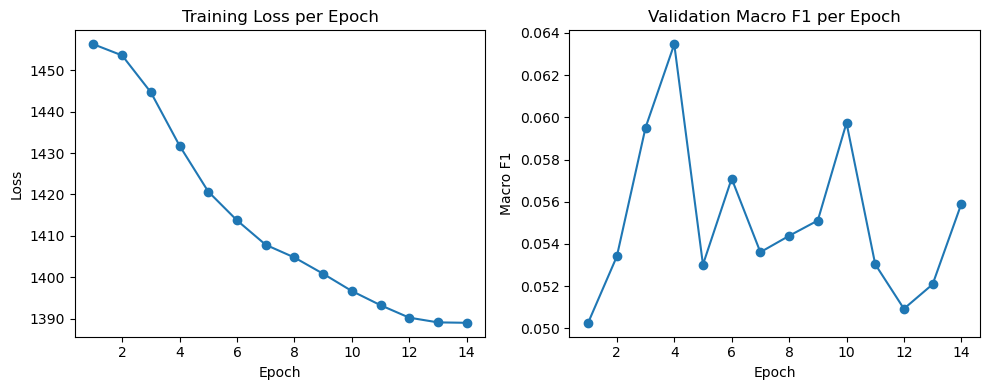

In [66]:
model = CNNRNNClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    num_classes=len(new_label2idx),
    embedding_weights=None
)

train_model_new(model, train_loader_new, test_loader_new, num_epochs=100, save_path="cnn_rnn_model_new.pt")


Epoch 1/500: 100%|██████████| 700/700 [00:22<00:00, 31.67it/s, loss=2.08]


Epoch 1, Loss: 1456.5466, Val Macro F1: 0.0530
✅ Model saved.


Epoch 2/500: 100%|██████████| 700/700 [00:22<00:00, 31.14it/s, loss=2.04]


Epoch 2, Loss: 1453.0835, Val Macro F1: 0.0576
✅ Model saved.


Epoch 3/500: 100%|██████████| 700/700 [00:22<00:00, 31.66it/s, loss=2.06]


Epoch 3, Loss: 1444.1070, Val Macro F1: 0.0579
✅ Model saved.


Epoch 4/500: 100%|██████████| 700/700 [00:22<00:00, 31.41it/s, loss=2.08]


Epoch 4, Loss: 1431.3195, Val Macro F1: 0.0636
✅ Model saved.


Epoch 5/500: 100%|██████████| 700/700 [00:22<00:00, 30.48it/s, loss=2.01]


Epoch 5, Loss: 1422.4554, Val Macro F1: 0.0571


Epoch 6/500: 100%|██████████| 700/700 [00:22<00:00, 30.48it/s, loss=2.01]


Epoch 6, Loss: 1414.3098, Val Macro F1: 0.0580


Epoch 7/500: 100%|██████████| 700/700 [00:22<00:00, 30.48it/s, loss=1.99]


Epoch 7, Loss: 1408.9174, Val Macro F1: 0.0542


Epoch 8/500: 100%|██████████| 700/700 [00:22<00:00, 31.61it/s, loss=2.1] 


Epoch 8, Loss: 1405.3063, Val Macro F1: 0.0571


Epoch 9/500: 100%|██████████| 700/700 [00:22<00:00, 31.63it/s, loss=1.91]


Epoch 9, Loss: 1400.6003, Val Macro F1: 0.0568


Epoch 10/500: 100%|██████████| 700/700 [00:21<00:00, 31.82it/s, loss=1.98]


Epoch 10, Loss: 1397.7420, Val Macro F1: 0.0556


Epoch 11/500: 100%|██████████| 700/700 [00:22<00:00, 31.37it/s, loss=1.95]


Epoch 11, Loss: 1394.1996, Val Macro F1: 0.0656
✅ Model saved.


Epoch 12/500: 100%|██████████| 700/700 [00:22<00:00, 31.55it/s, loss=1.98]


Epoch 12, Loss: 1391.1347, Val Macro F1: 0.0605


Epoch 13/500: 100%|██████████| 700/700 [00:22<00:00, 30.56it/s, loss=2.05]


Epoch 13, Loss: 1388.1828, Val Macro F1: 0.0642


Epoch 14/500: 100%|██████████| 700/700 [00:22<00:00, 30.95it/s, loss=1.99]


Epoch 14, Loss: 1380.4941, Val Macro F1: 0.0793
✅ Model saved.


Epoch 15/500: 100%|██████████| 700/700 [00:22<00:00, 31.43it/s, loss=1.85]


Epoch 15, Loss: 1372.6803, Val Macro F1: 0.0867
✅ Model saved.


Epoch 16/500: 100%|██████████| 700/700 [00:22<00:00, 31.56it/s, loss=1.97]


Epoch 16, Loss: 1358.1724, Val Macro F1: 0.0977
✅ Model saved.


Epoch 17/500: 100%|██████████| 700/700 [00:22<00:00, 31.16it/s, loss=2]   


Epoch 17, Loss: 1338.9747, Val Macro F1: 0.1451
✅ Model saved.


Epoch 18/500: 100%|██████████| 700/700 [00:22<00:00, 31.41it/s, loss=1.97]


Epoch 18, Loss: 1320.3853, Val Macro F1: 0.1396


Epoch 19/500: 100%|██████████| 700/700 [00:23<00:00, 30.42it/s, loss=1.95]


Epoch 19, Loss: 1302.8441, Val Macro F1: 0.1150


Epoch 20/500: 100%|██████████| 700/700 [00:22<00:00, 30.62it/s, loss=1.73]


Epoch 20, Loss: 1282.9507, Val Macro F1: 0.1123


Epoch 21/500: 100%|██████████| 700/700 [00:23<00:00, 30.35it/s, loss=1.68]


Epoch 21, Loss: 1266.0840, Val Macro F1: 0.1227


Epoch 22/500: 100%|██████████| 700/700 [00:22<00:00, 30.66it/s, loss=1.91]


Epoch 22, Loss: 1248.8658, Val Macro F1: 0.1377


Epoch 23/500: 100%|██████████| 700/700 [00:22<00:00, 31.52it/s, loss=1.77]


Epoch 23, Loss: 1234.4811, Val Macro F1: 0.1170


Epoch 24/500: 100%|██████████| 700/700 [00:22<00:00, 31.42it/s, loss=1.82]


Epoch 24, Loss: 1223.6479, Val Macro F1: 0.1347


Epoch 25/500: 100%|██████████| 700/700 [00:22<00:00, 31.30it/s, loss=1.82]


Epoch 25, Loss: 1214.7070, Val Macro F1: 0.1454
✅ Model saved.


Epoch 26/500: 100%|██████████| 700/700 [00:22<00:00, 31.63it/s, loss=1.68]


Epoch 26, Loss: 1205.8034, Val Macro F1: 0.1166


Epoch 27/500: 100%|██████████| 700/700 [00:22<00:00, 31.76it/s, loss=1.8] 


Epoch 27, Loss: 1195.3914, Val Macro F1: 0.1278


Epoch 28/500: 100%|██████████| 700/700 [00:22<00:00, 31.67it/s, loss=1.71]


Epoch 28, Loss: 1190.4722, Val Macro F1: 0.1330


Epoch 29/500: 100%|██████████| 700/700 [00:22<00:00, 31.45it/s, loss=1.61]


Epoch 29, Loss: 1184.9117, Val Macro F1: 0.1480
✅ Model saved.


Epoch 30/500: 100%|██████████| 700/700 [00:22<00:00, 31.51it/s, loss=1.83]


Epoch 30, Loss: 1180.4949, Val Macro F1: 0.1486
✅ Model saved.


Epoch 31/500: 100%|██████████| 700/700 [00:22<00:00, 31.21it/s, loss=1.91]


Epoch 31, Loss: 1173.1940, Val Macro F1: 0.1654
✅ Model saved.


Epoch 32/500: 100%|██████████| 700/700 [00:22<00:00, 31.13it/s, loss=1.53]


Epoch 32, Loss: 1165.6537, Val Macro F1: 0.1423


Epoch 33/500: 100%|██████████| 700/700 [00:22<00:00, 31.17it/s, loss=1.76]


Epoch 33, Loss: 1160.8749, Val Macro F1: 0.1534


Epoch 34/500: 100%|██████████| 700/700 [00:22<00:00, 31.17it/s, loss=1.37]


Epoch 34, Loss: 1153.5080, Val Macro F1: 0.1394


Epoch 35/500: 100%|██████████| 700/700 [00:22<00:00, 31.34it/s, loss=1.45]


Epoch 35, Loss: 1146.7288, Val Macro F1: 0.1396


Epoch 36/500: 100%|██████████| 700/700 [00:22<00:00, 31.20it/s, loss=1.75]


Epoch 36, Loss: 1136.2695, Val Macro F1: 0.1423


Epoch 37/500: 100%|██████████| 700/700 [00:22<00:00, 31.35it/s, loss=1.59]


Epoch 37, Loss: 1129.5194, Val Macro F1: 0.1553


Epoch 38/500: 100%|██████████| 700/700 [00:22<00:00, 31.36it/s, loss=1.5] 


Epoch 38, Loss: 1120.2172, Val Macro F1: 0.1425


Epoch 39/500: 100%|██████████| 700/700 [00:23<00:00, 30.37it/s, loss=1.64]


Epoch 39, Loss: 1110.7344, Val Macro F1: 0.1432


Epoch 40/500: 100%|██████████| 700/700 [00:22<00:00, 31.14it/s, loss=1.63]


Epoch 40, Loss: 1101.6231, Val Macro F1: 0.1518


Epoch 41/500: 100%|██████████| 700/700 [00:22<00:00, 31.58it/s, loss=1.65]


Epoch 41, Loss: 1094.0573, Val Macro F1: 0.1614
⏹️ Early stopping triggered.
✅ Training complete.


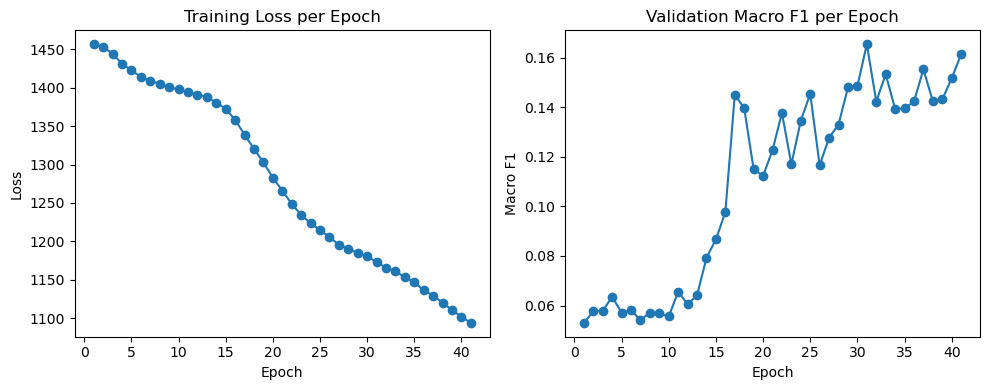

In [69]:
model = CNNRNNClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    num_classes=len(new_label2idx),
    embedding_weights=None
)

train_model_new(model, train_loader_new, test_loader_new, num_epochs=500, save_path="cnn_rnn_model_new_2.pt")


In [75]:
model = CNNRNNClassifier(
    vocab_size=len(new_vocab),
    embedding_dim=300,
    num_classes=len(new_label2idx),
    embedding_weights=None
)

model.load_state_dict(torch.load('cnn_rnn_model_new_2.pt'))
model.to(device)

y_true, y_pred = test_with_classification_report(model, test_loader_new, new_idx2label)

              precision    recall  f1-score   support

        ctrl     0.0000    0.0000    0.0000         0
         gpt     0.0000    0.0000    0.0000         0
        gpt2     0.0000    0.0000    0.0000         0
      grover     0.0000    0.0000    0.0000         0
         xlm     0.0000    0.0000    0.0000         0
       xlnet     0.0000    0.0000    0.0000         0
        pplm     0.0000    0.0000    0.0000         0
       human     0.6699    0.3929    0.4953      1400
        fair     0.0000    0.0000    0.0000         0

   micro avg     0.6699    0.3929    0.4953      1400
   macro avg     0.0744    0.0437    0.0550      1400
weighted avg     0.6699    0.3929    0.4953      1400



/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/